In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import glob
from matplotlib.ticker import MultipleLocator
import subprocess
from scipy.optimize import curve_fit
from scipy.stats import chi2
plt.rcParams["xtick.top"] = True    # enable top x-ticks
plt.rcParams["ytick.right"] = True  # enable right y-ticks
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [2]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))
frac = 0.9542011788469517 # (Na21/(p+Na21)) amount of energy the daughter nucleus gets of the total energy released in the decay
frac_err = 1.032071836027589e-10 # uncertainty of the fraction
mp  = 1007825.031898
mNa = 20997654.459
mNe = 19992440.17525
S1p = 5504.1000
S2p = 7935.9963
QB  = 17600

def y1(x, E1):
    return E1 + 0*x
def y2(x, E1, E2): # E1 may be fixed
    M = mp/mNa
    return E2 - 2*M*np.sqrt(E1*E2)*x + E1*M**2

In [3]:
EE2p = np.array([])
E1 = np.array([])
E2 = np.array([])
Q2p = np.array([])
theta = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E", "E1", "E2", "Q2p", "Theta"],
                            cut="Q2p>0"):
    EE2p=np.append(EE2p, ak.flatten(batch.E))
    E1=np.append(E1, batch.E1)
    E2=np.append(E2, batch.E2)
    Q2p=np.append(Q2p, batch.Q2p)
    theta=np.append(theta, batch.Theta)

import re

E_excited = []
E_excited_err = []

pattern = re.compile(r"21NA\s+L\s+([\d.]+)\s+([\d.]+)")

with open("Na21_ensdf.txt", "r") as f:
    for line in f:
        match = pattern.search(line)
        if match:
            E_excited.append(float(match.group(1)))
            E_excited_err.append(float(match.group(2)))

E_excited = np.array(E_excited)
E_excited_err = np.array(E_excited_err)

Erik_Es = np.array([3.52,3.86,4.29,4.46,5.02,5.15,5.37,5.95,6.20,6.47,7.49,8.13,8.31,8.42,8.55,8.8,8.97,9.0,9.8,10.2,10.7])*1e3
Erik_Es_err = np.array([2,1,2,2,1,2,1,2,1,2,2,2,2,2,0,0,1,0,1,0,2])



5748 -> ENSDF: [5770.]


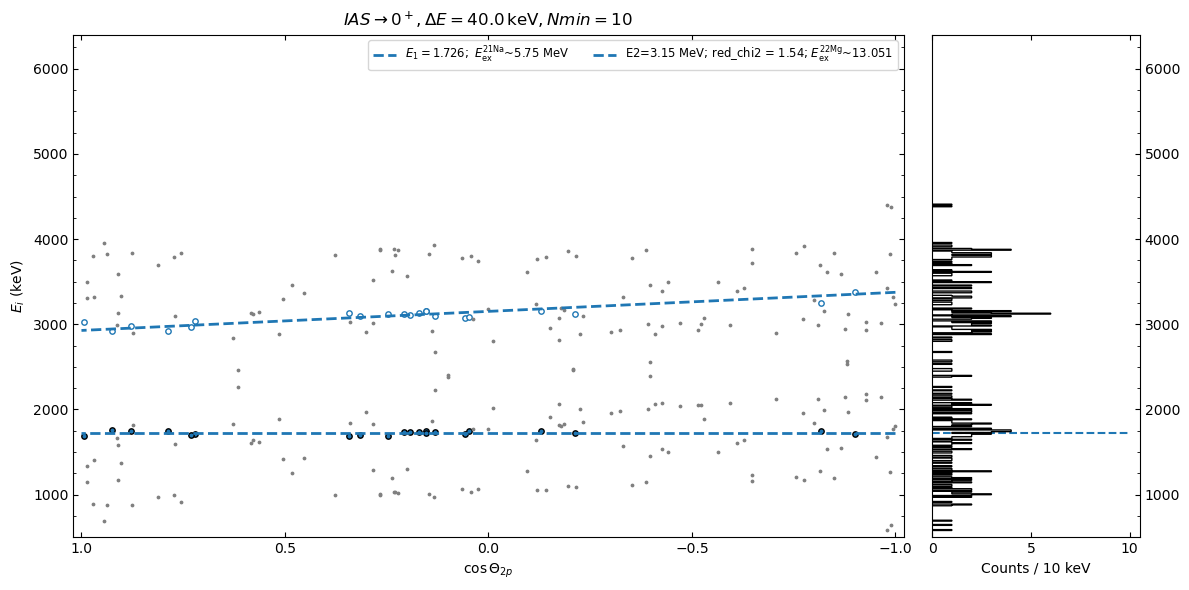

3565 -> ENSDF: [3544.3]


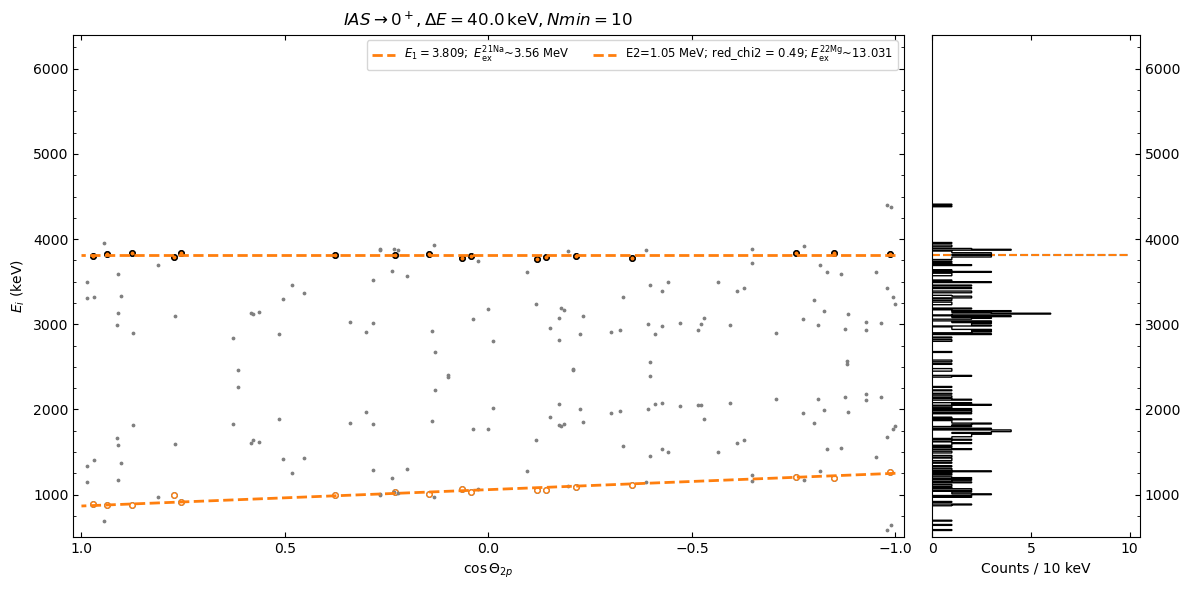

No suitable exctited level was found for 4504


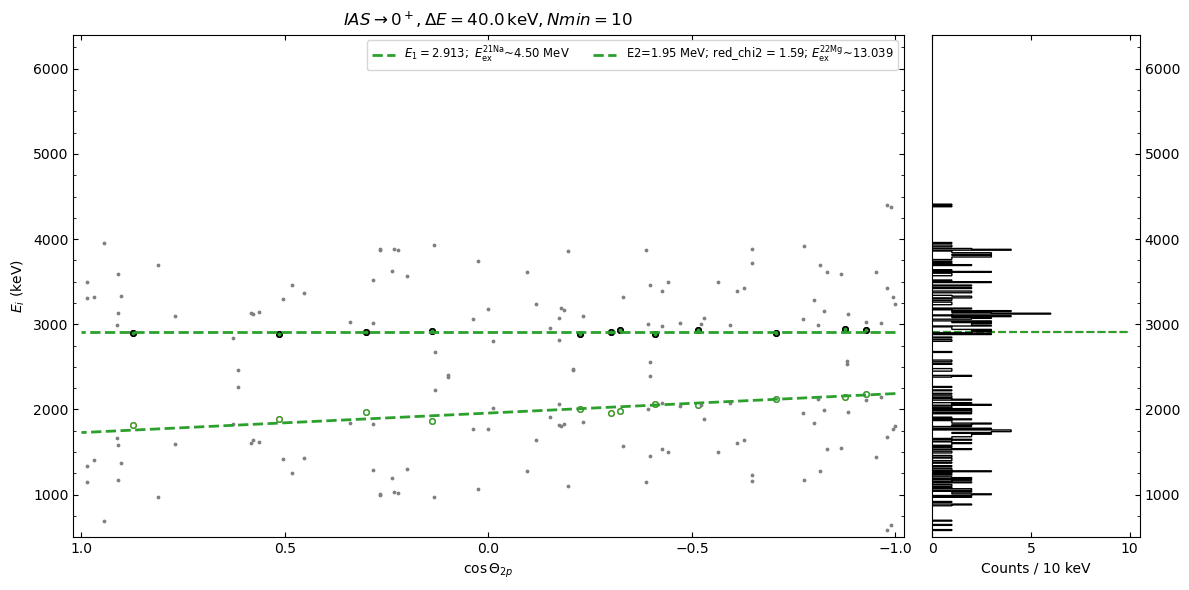

No suitable exctited level was found for 4387


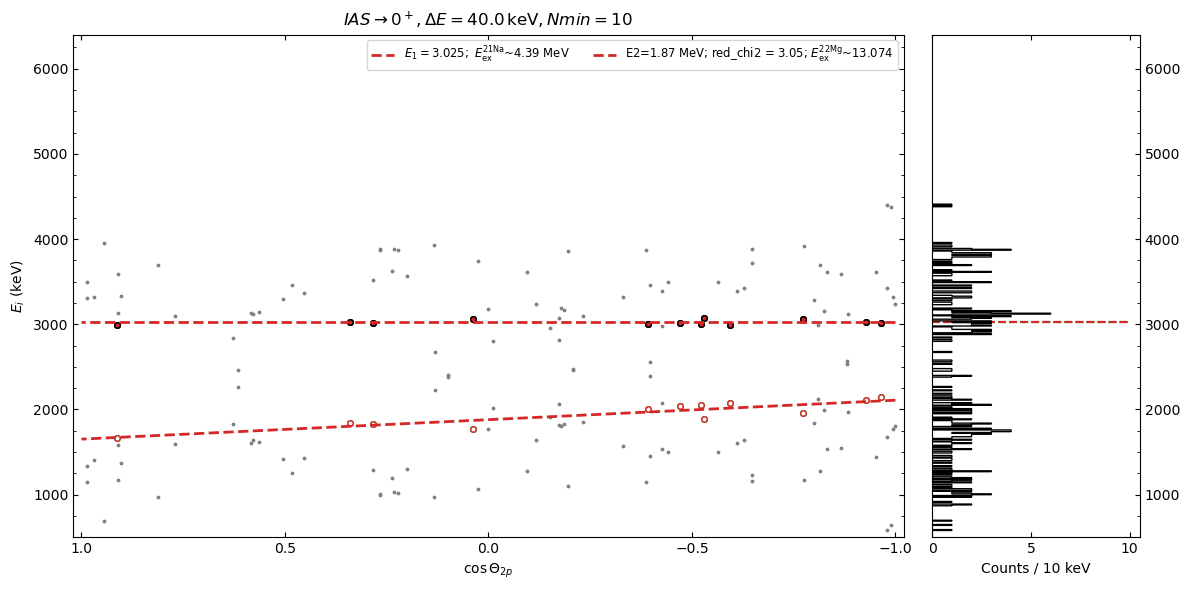

The reduced chi2 values from the fits
[1.541 0.487 1.593 3.054]

Peaks identified by previous studies of 21Na(found values)
[5748. 3565.]

Peaks found in Ensdf / Erik ?
[(True, False), (True, False)]

Peaks not found to match any previously found levels in 21Na
[4504. 4387.]

E1 energies:
[1726. 3809. 2913. 3025.]
E2 energies:
[3148. 1050. 1951. 1874.]
Excited state energies of 21Na:
[5748. 3565. 4504. 4387.]


In [14]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################
lim = (5040, 5210)

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 40.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands0, e2bands0, cos1bands0, cos2bands0 = [], [], [], []
Ex, E1s,E2s = [], [], []
assigned_counts0 = [] ## following order of Ex

# ---- Q2p gate ----
m   = 6400
title = fr"$IAS \rightarrow 0^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
total_counts = len(e1)
N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = (lim[0]+lim[1])/2+S2p  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts0.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        assigned_counts0.append(0)

    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands0.append(E1_band)
    e2bands0.append(E2_band)
    cos1bands0.append(cos1_band)
    cos2bands0.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,10,color, ls='--')
        unused_cos0 = cos_th[event_band_idx == -1]
        unused_e10 = e1[event_band_idx == -1]
        unused_e20 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)

    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit)/1e3:.3f}")

    Ex.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)

    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(500,m)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    # ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))


3879 -> ENSDF: [3862.2]
3879 -> Erik: [3860.]


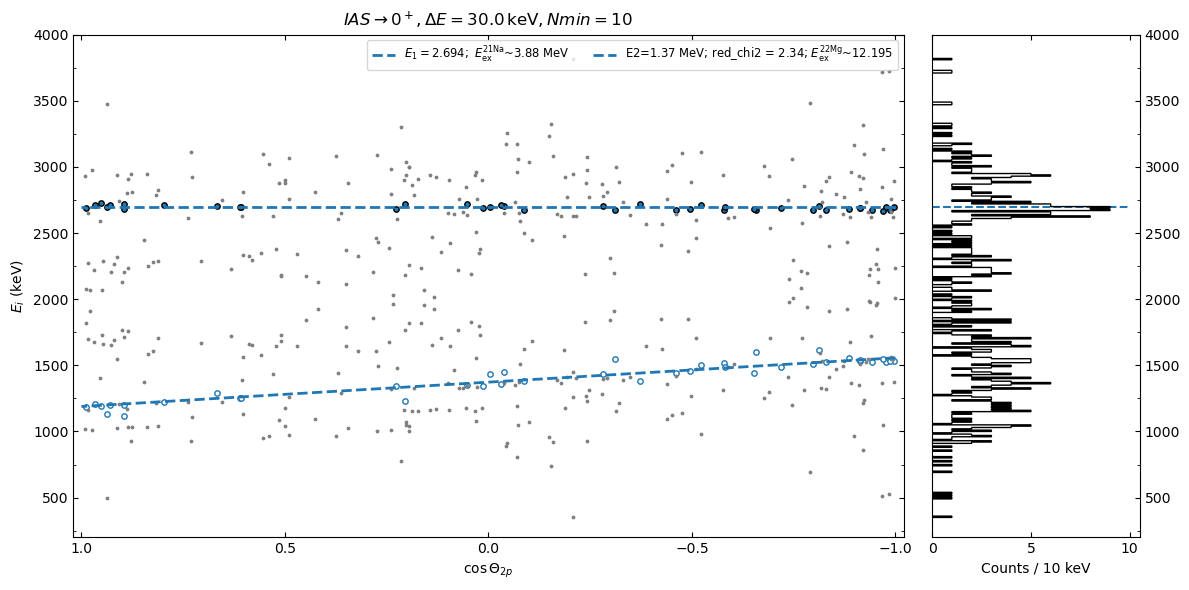

No suitable exctited level was found for 3941


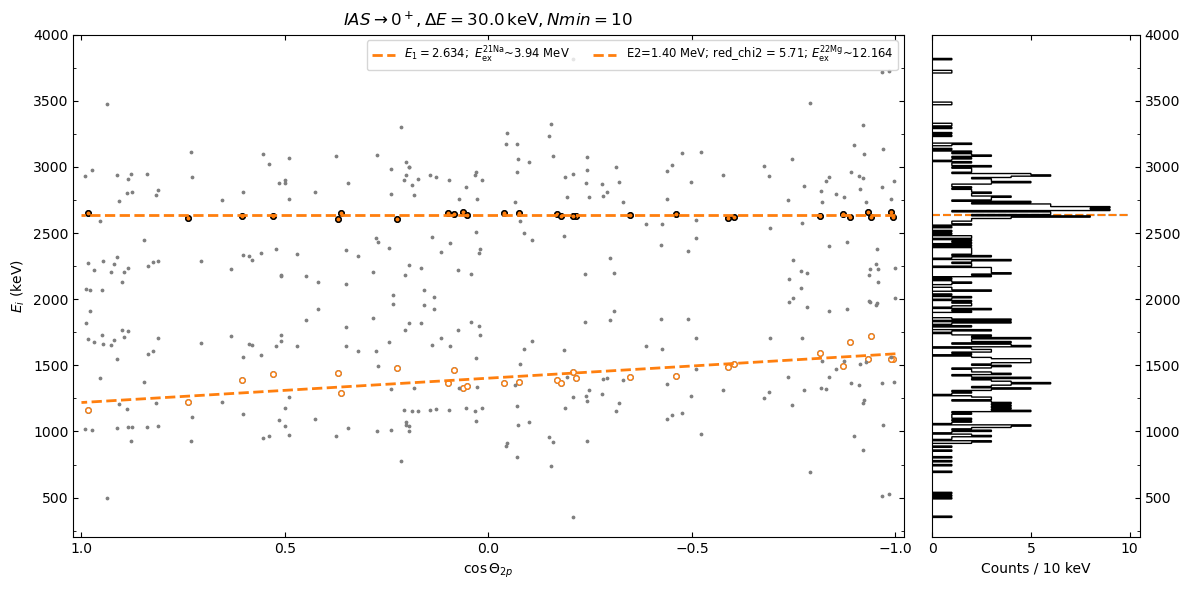

3653 -> ENSDF: [3678.9]


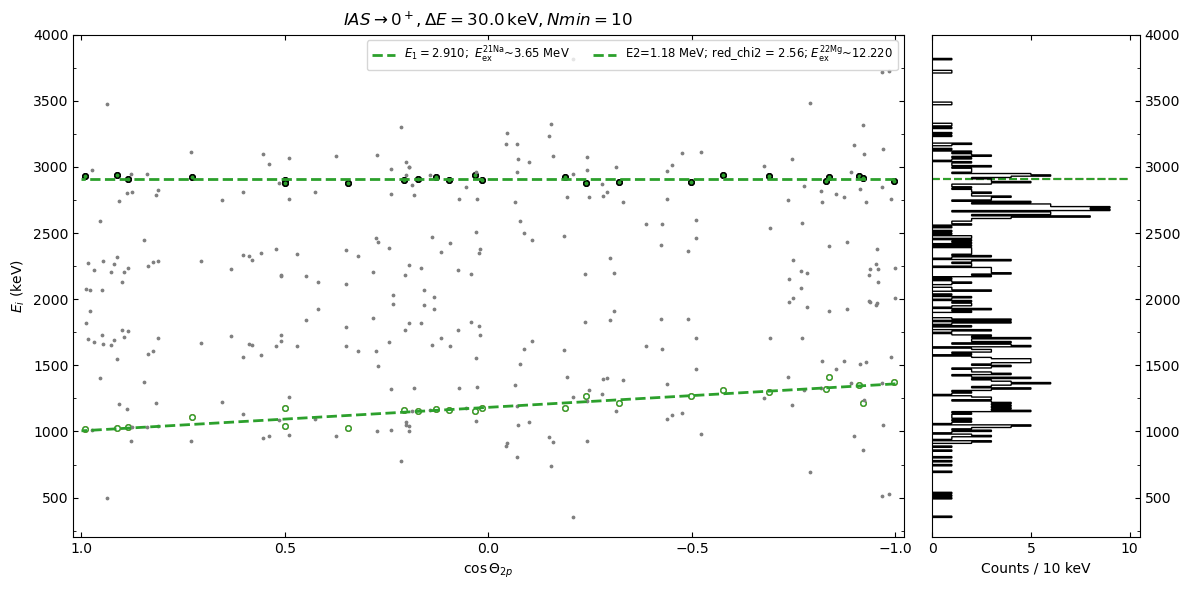

4394 -> ENSDF: [4419.]


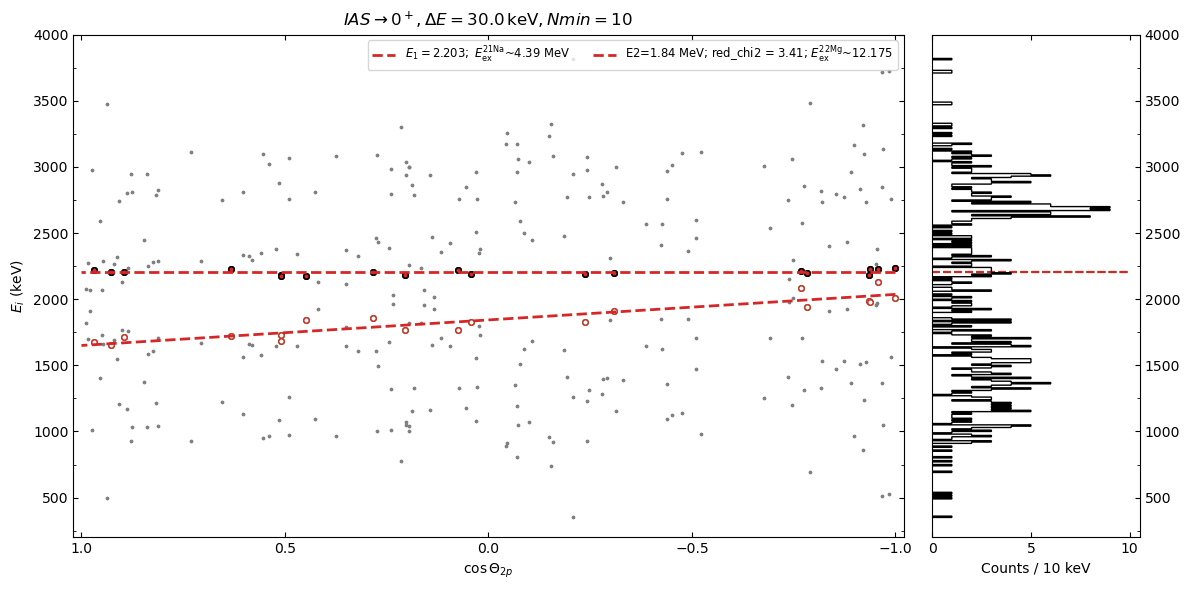

No suitable exctited level was found for 3812


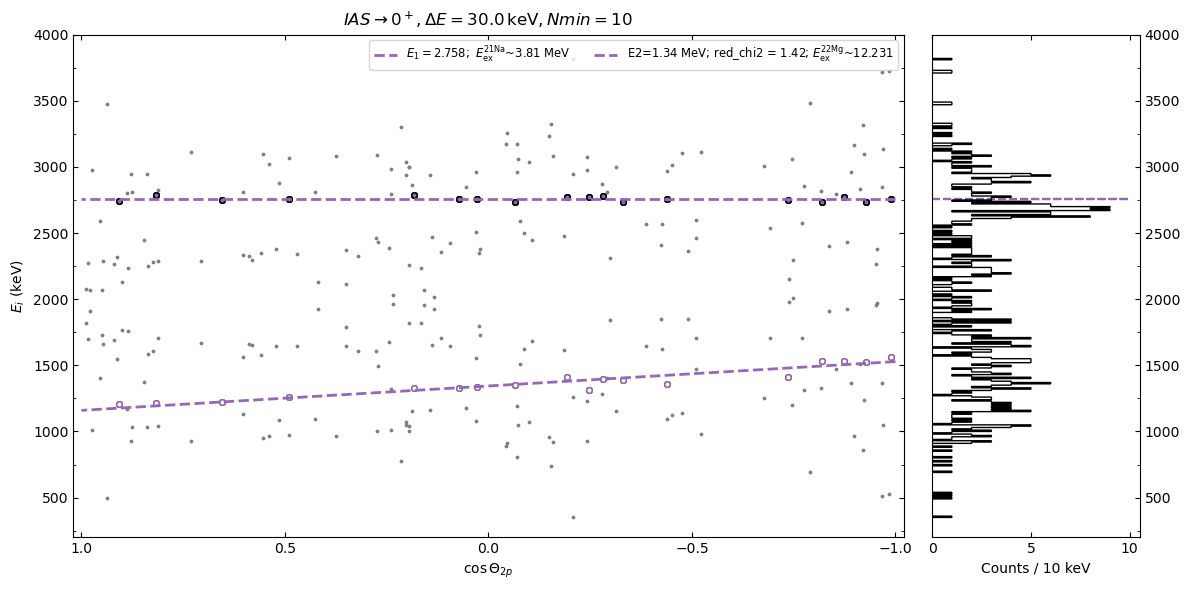

No suitable exctited level was found for 3594


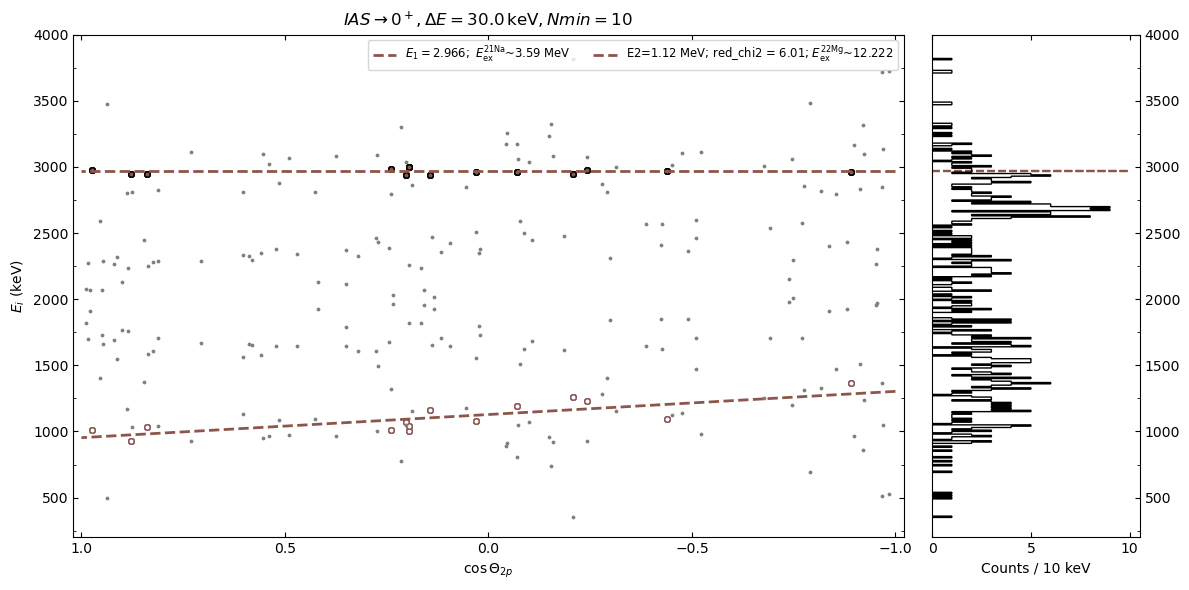

4959 -> ENSDF: [4984.]


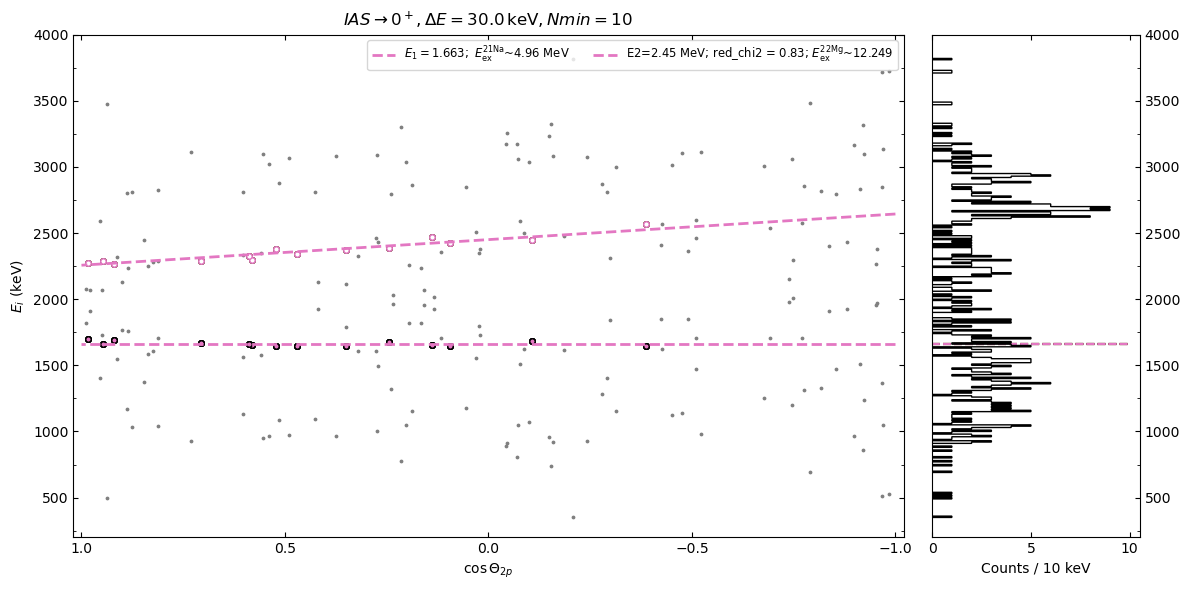

No suitable exctited level was found for 3750


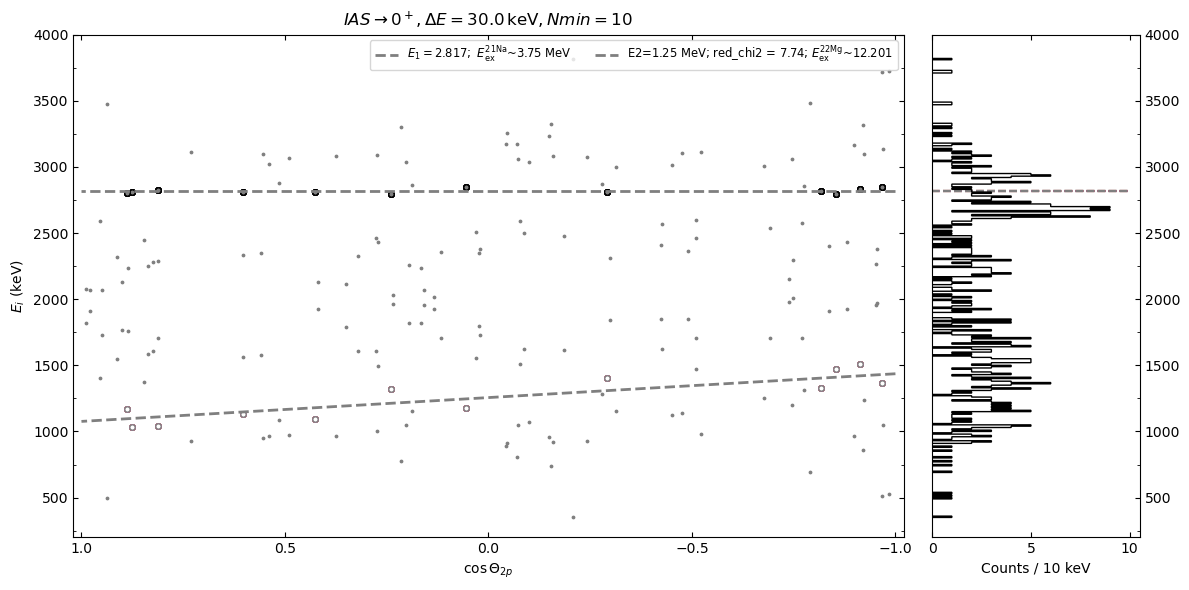

No suitable exctited level was found for 3467


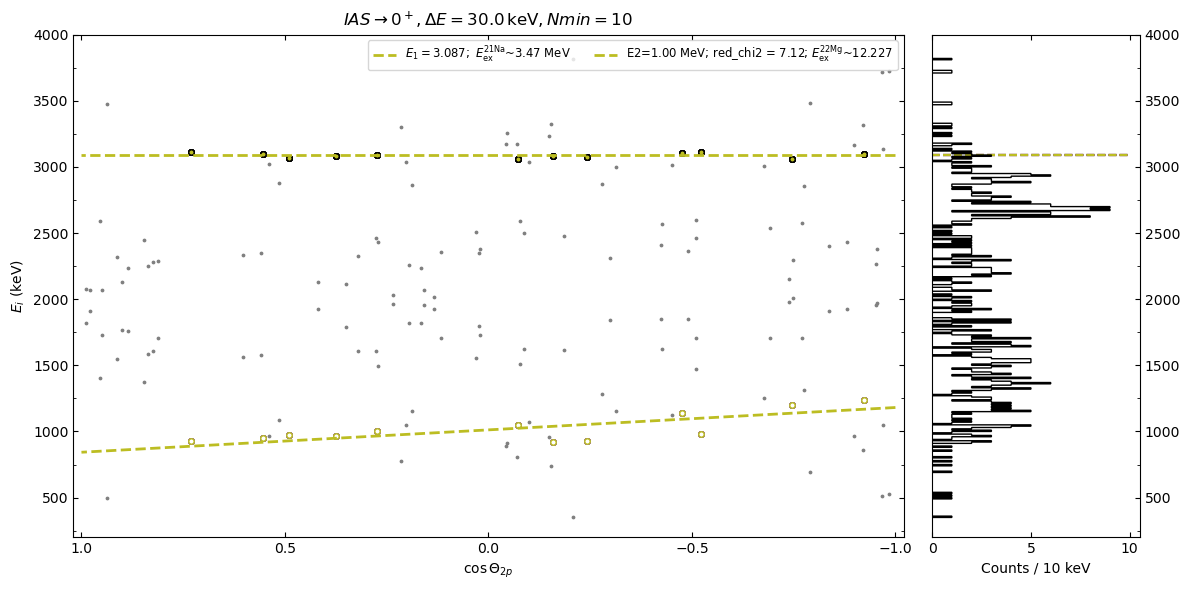

The reduced chi2 values from the fits
[2.343 5.714 2.559 3.413 1.421 6.008 0.827 7.737 7.121]

Peaks identified by previous studies of 21Na(found values)
[3879. 3653. 4394. 4959.]

Peaks found in Ensdf / Erik ?
[(True, True), (True, False), (True, False), (True, False)]

Peaks not found to match any previously found levels in 21Na
[3941. 3812. 3594. 3750. 3467.]

E1 energies:
[2694. 2634. 2910. 2203. 2758. 2966. 1663. 2817. 3087.]
E2 energies:
[1367. 1397. 1176. 1838. 1338. 1121. 2447. 1250. 1005.]
Excited state energies of 21Na:
[3879. 3941. 3653. 4394. 3812. 3594. 4959. 3750. 3467.]


In [16]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################
lim = (4160, 4380)

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 30.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands0, e2bands0, cos1bands0, cos2bands0 = [], [], [], []
Ex, E1s,E2s = [], [], []
assigned_counts0 = [] ## following order of Ex

# ---- Q2p gate ----
m   = 6400
title = fr"$IAS \rightarrow 0^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
total_counts = len(e1)
N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = (lim[0]+lim[1])/2+S2p  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts0.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        assigned_counts0.append(0)

    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands0.append(E1_band)
    e2bands0.append(E2_band)
    cos1bands0.append(cos1_band)
    cos2bands0.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,10,color, ls='--')
        unused_cos0 = cos_th[event_band_idx == -1]
        unused_e10 = e1[event_band_idx == -1]
        unused_e20 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)

    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit)/1e3:.3f}")

    Ex.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)

    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(200,4000)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    # ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))


5447 -> ENSDF: [5457.]


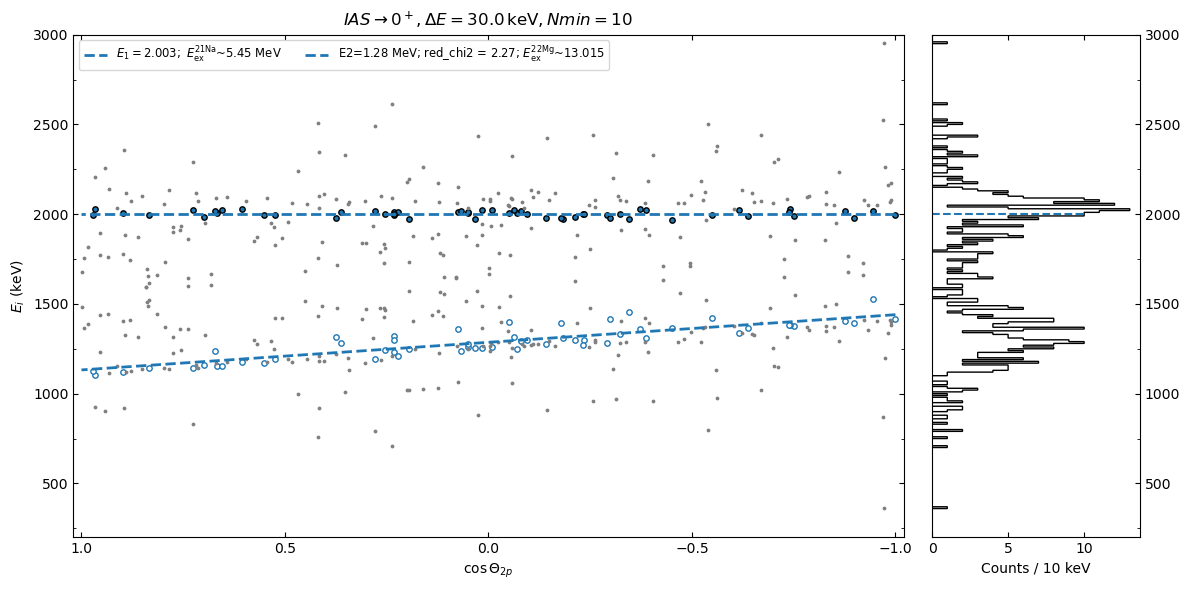

5372 -> ENSDF: [5380.]
5372 -> Erik: [5370.]


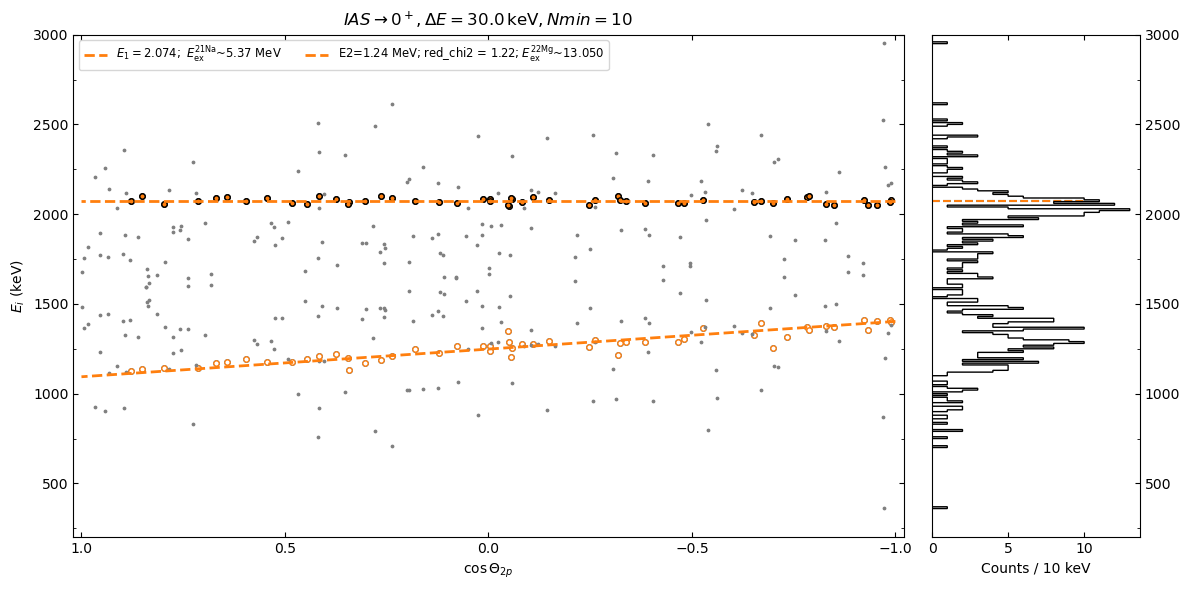

No suitable exctited level was found for 5594


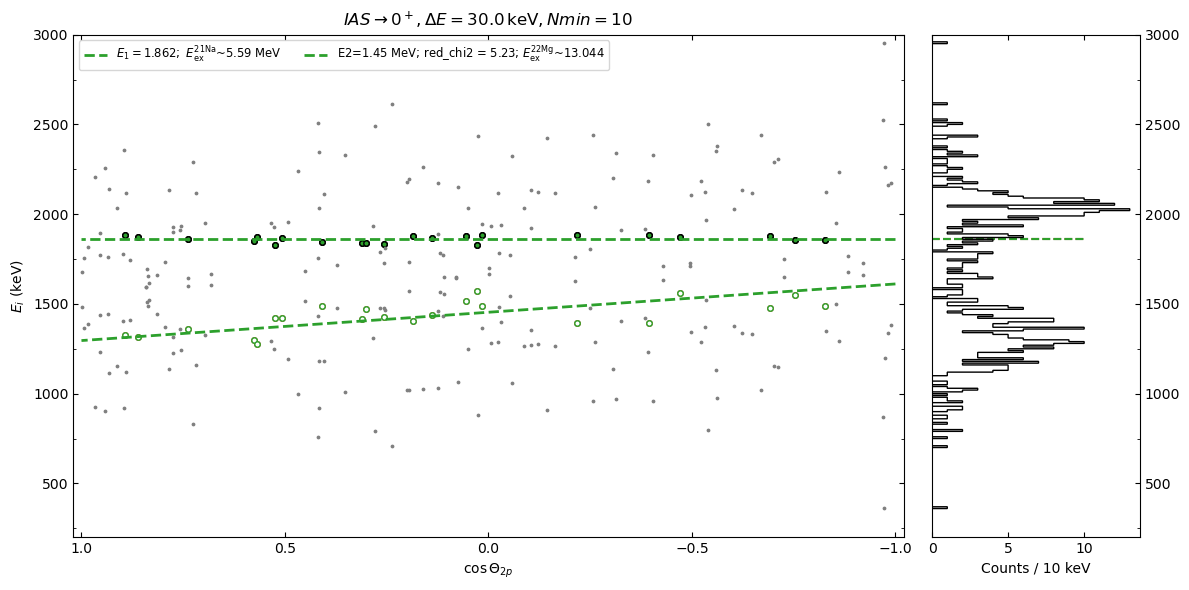

No suitable exctited level was found for 5707


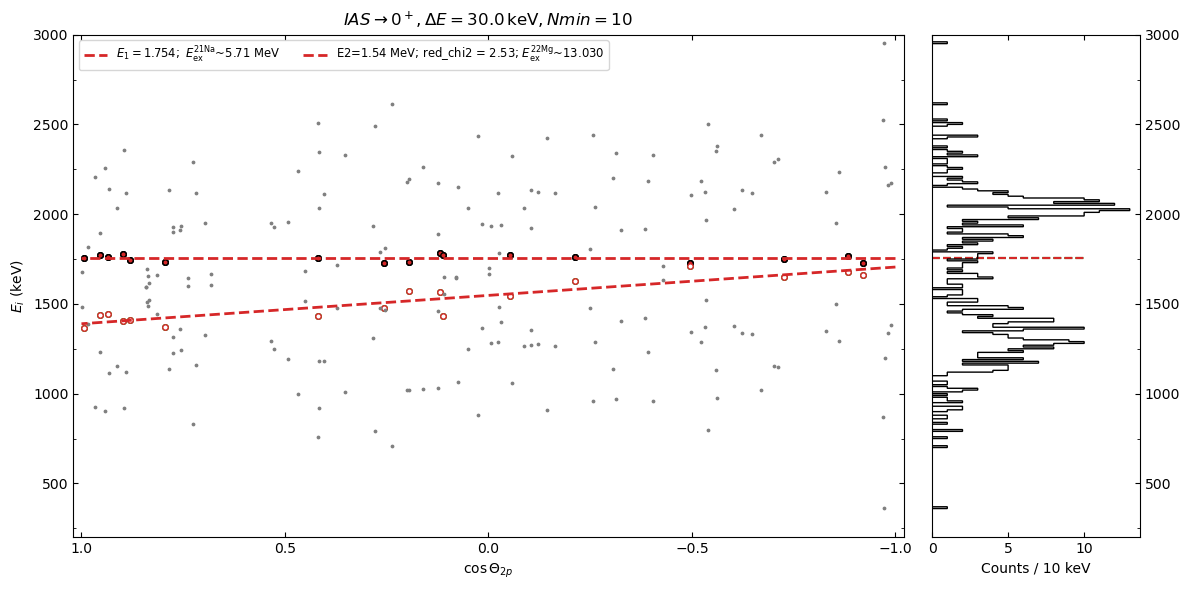

No suitable exctited level was found for 5520


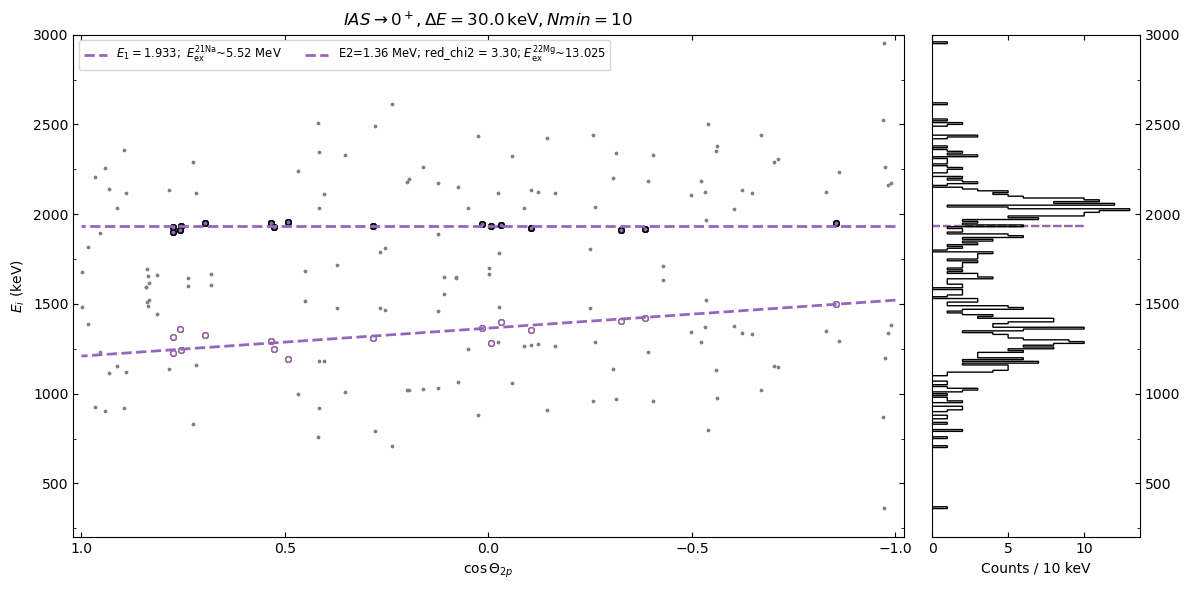

No suitable exctited level was found for 5317


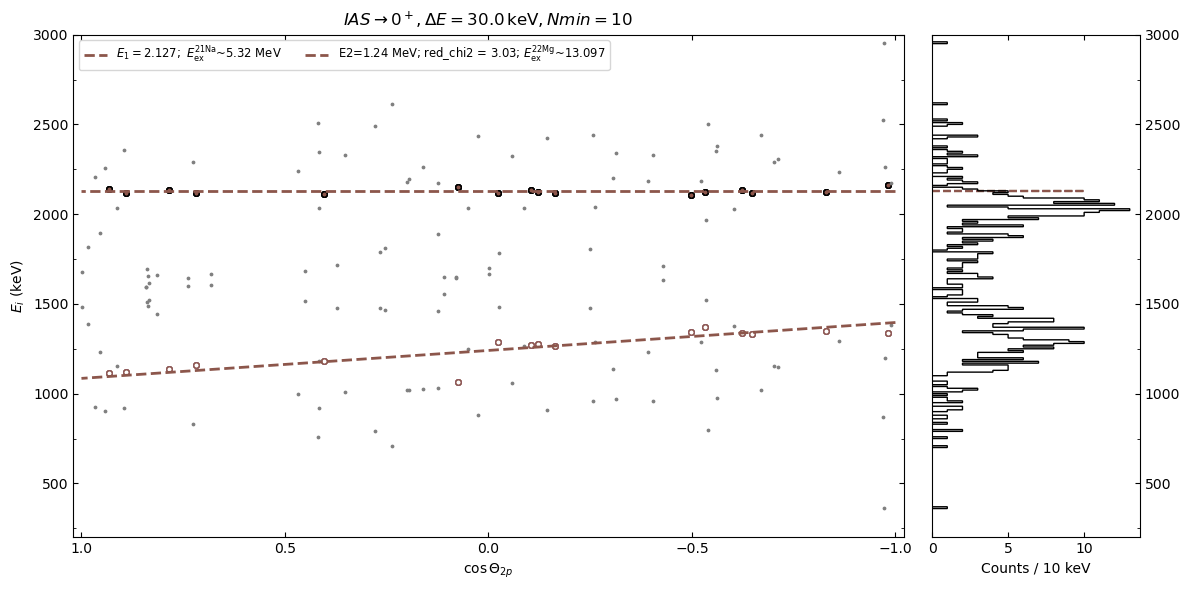

5803 -> ENSDF: [5815. 5828.]


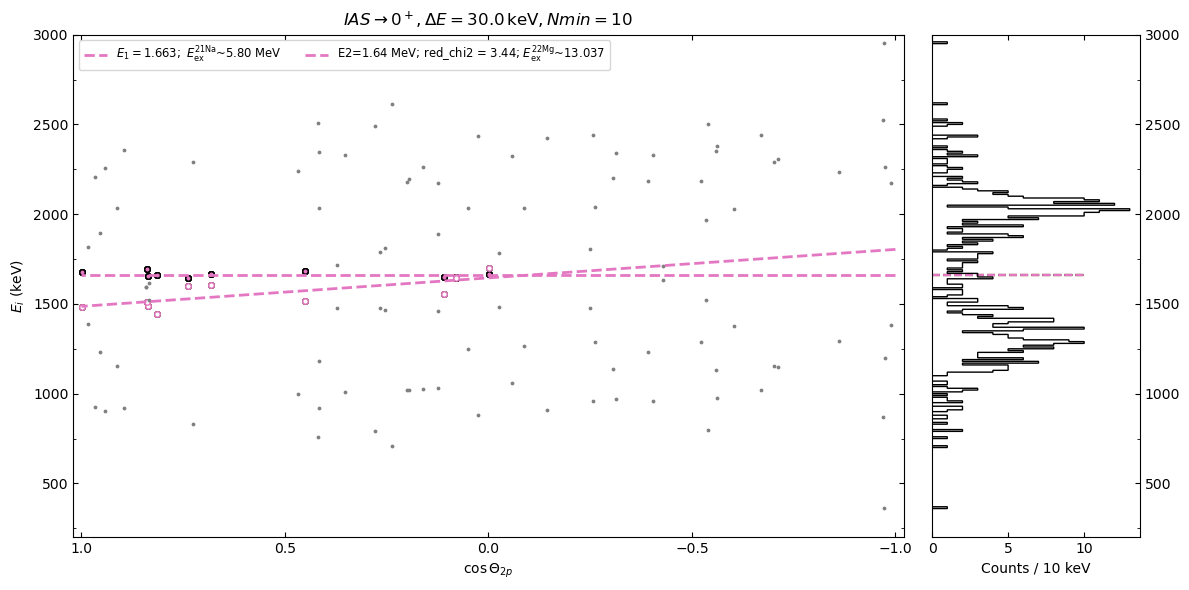

The reduced chi2 values from the fits
[2.271 1.216 5.232 2.525 3.299 3.031 3.438]

Peaks identified by previous studies of 21Na(found values)
[5447. 5372. 5803.]

Peaks found in Ensdf / Erik ?
[(True, False), (True, True), (True, False)]

Peaks not found to match any previously found levels in 21Na
[5594. 5707. 5520. 5317.]

E1 energies:
[2003. 2074. 1862. 1754. 1933. 2127. 1663.]
E2 energies:
[1282. 1244. 1449. 1543. 1361. 1236. 1641.]
Excited state energies of 21Na:
[5447. 5372. 5594. 5707. 5520. 5317. 5803.]


In [20]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################
lim = (3370,3580)

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 30.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands0, e2bands0, cos1bands0, cos2bands0 = [], [], [], []
Ex, E1s,E2s = [], [], []
assigned_counts0 = [] ## following order of Ex

# ---- Q2p gate ----
m   = 6400
title = fr"$IAS \rightarrow 0^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
total_counts = len(e1)
N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = 13050 #(lim[0]+lim[1])/2+S2p+1634  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts0.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        assigned_counts0.append(0)

    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands0.append(E1_band)
    e2bands0.append(E2_band)
    cos1bands0.append(cos1_band)
    cos2bands0.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,10,color, ls='--')
        unused_cos0 = cos_th[event_band_idx == -1]
        unused_e10 = e1[event_band_idx == -1]
        unused_e20 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)

    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit+1634)/1e3:.3f}")

    Ex.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)

    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(200,3000)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    # ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))


5442 -> ENSDF: [5457.]


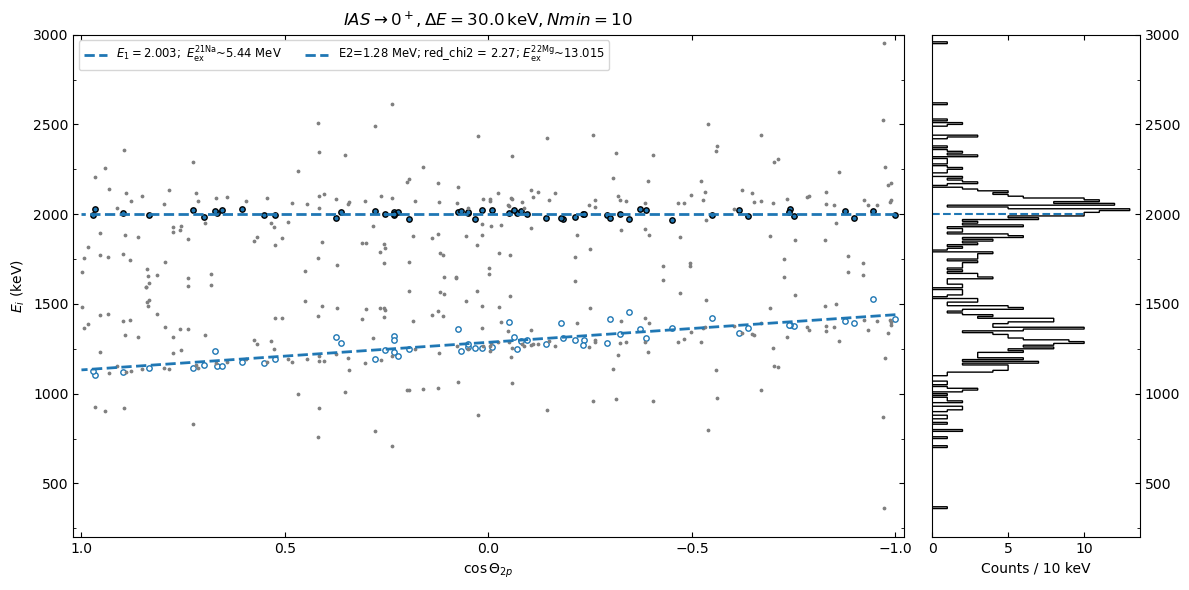

5367 -> ENSDF: [5380.]
5367 -> Erik: [5370.]


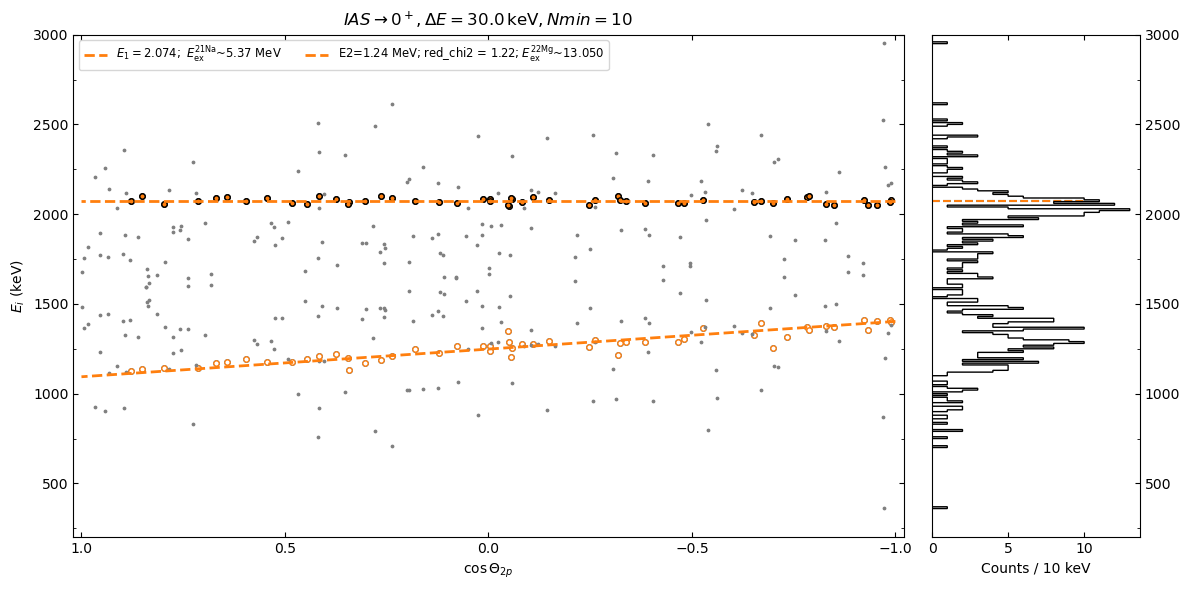

No suitable exctited level was found for 5589


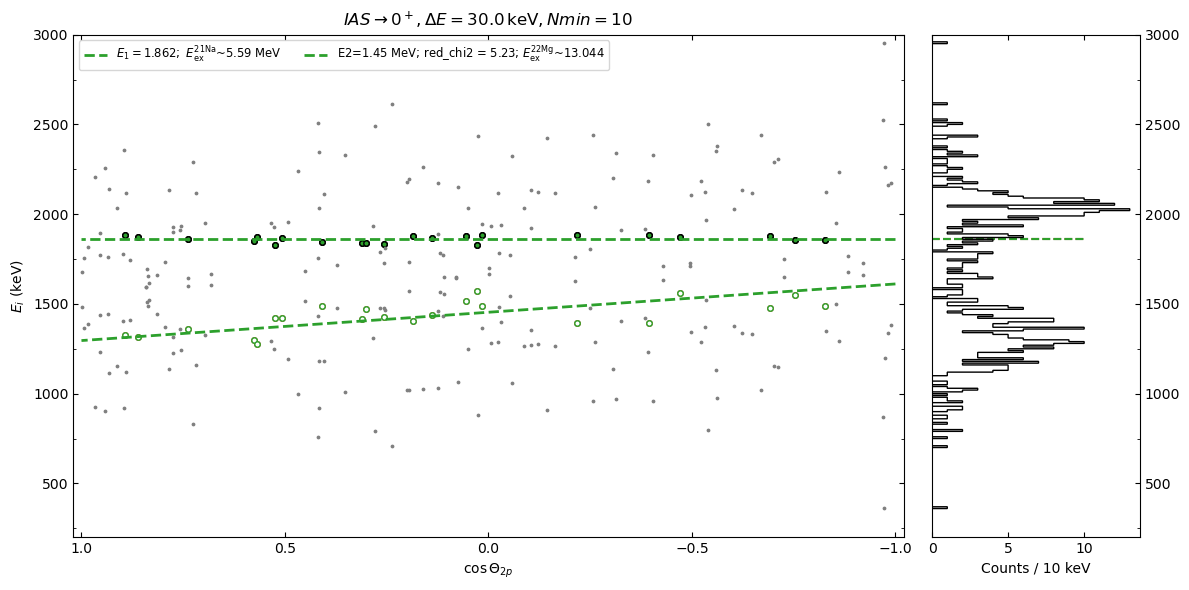

No suitable exctited level was found for 5702


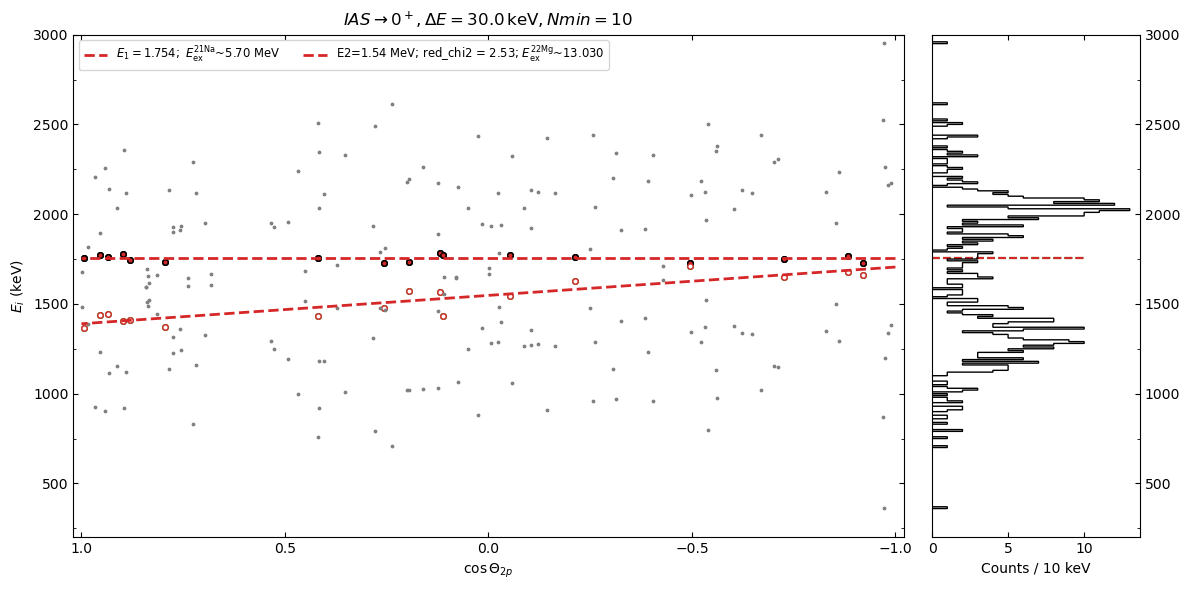

No suitable exctited level was found for 5515


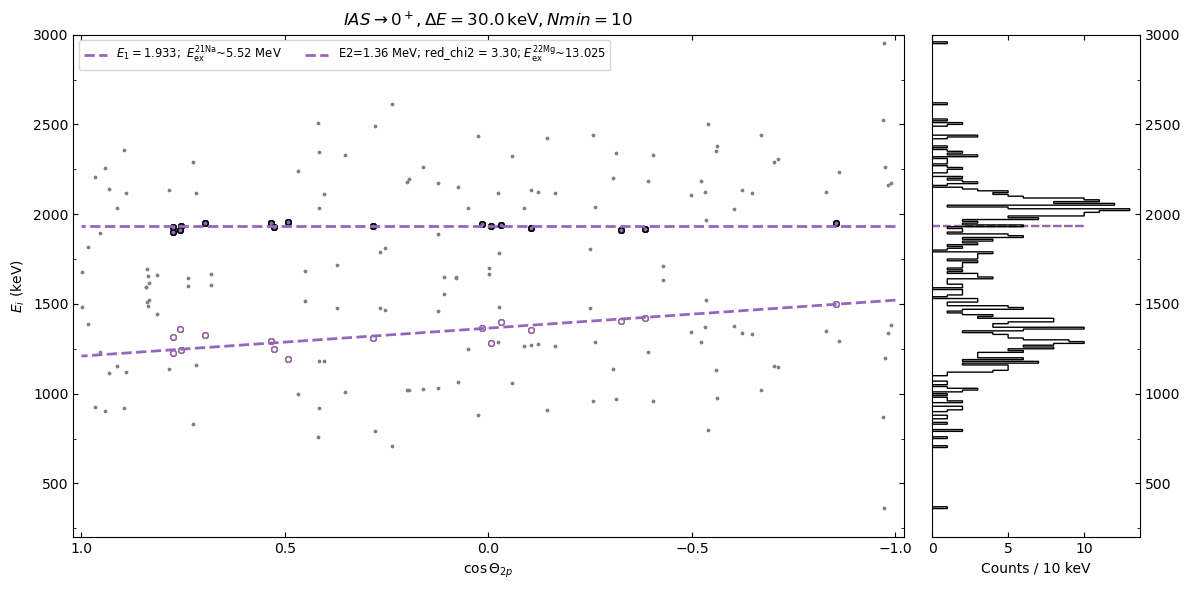

No suitable exctited level was found for 5312


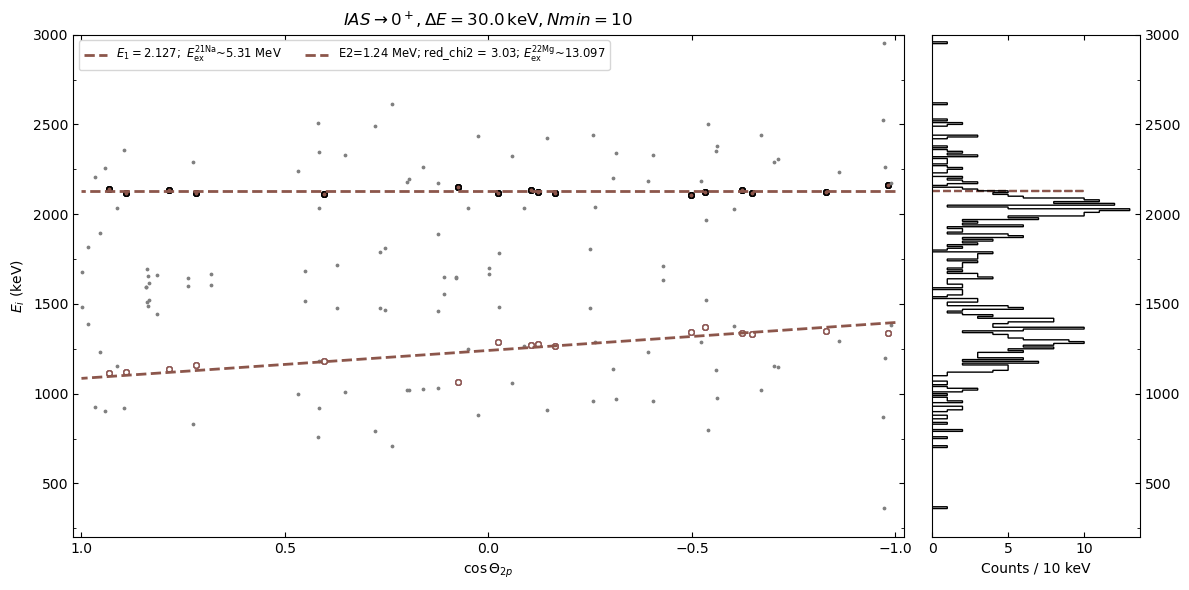

5798 -> ENSDF: [5770. 5815. 5828.]


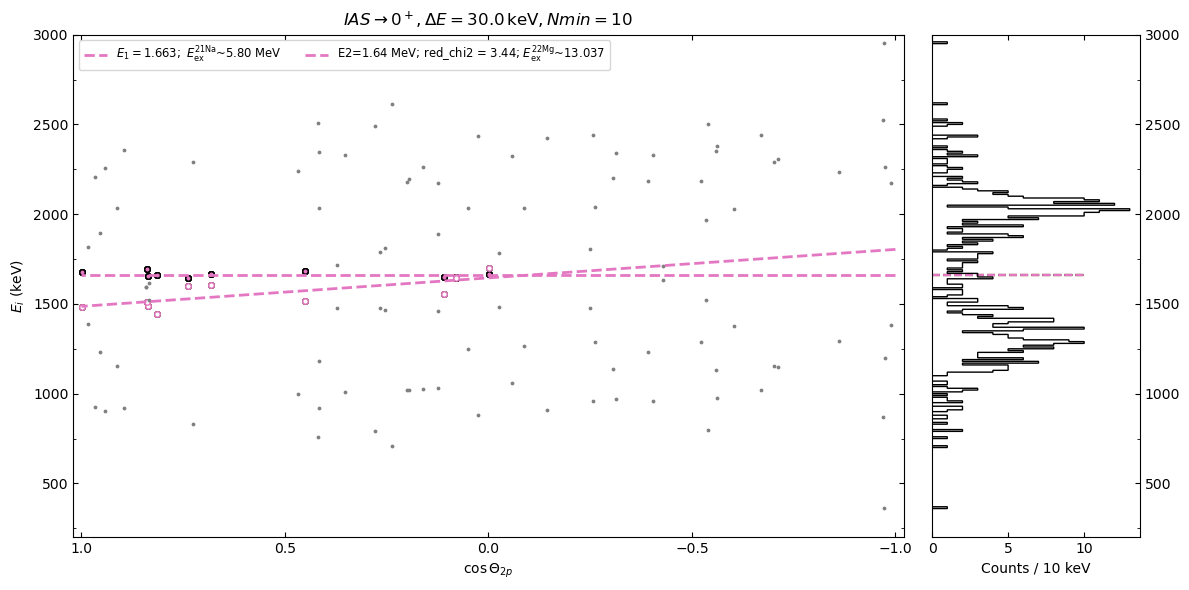

The reduced chi2 values from the fits
[2.271 1.216 5.232 2.525 3.299 3.031 3.438]

Peaks identified by previous studies of 21Na(found values)
[5442. 5367. 5798.]

Peaks found in Ensdf / Erik ?
[(True, False), (True, True), (True, False)]

Peaks not found to match any previously found levels in 21Na
[5589. 5702. 5515. 5312.]

E1 energies:
[2003. 2074. 1862. 1754. 1933. 2127. 1663.]
E2 energies:
[1282. 1244. 1449. 1543. 1361. 1236. 1641.]
Excited state energies of 21Na:
[5442. 5367. 5589. 5702. 5515. 5312. 5798.]


In [23]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################
lim = (3370,3580)

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 30.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands0, e2bands0, cos1bands0, cos2bands0 = [], [], [], []
Ex, E1s,E2s = [], [], []
assigned_counts0 = [] ## following order of Ex

# ---- Q2p gate ----
m   = 6400
title = fr"$IAS \rightarrow 0^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
total_counts = len(e1)
N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = (lim[0]+lim[1])/2+S2p+1634  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts0.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        assigned_counts0.append(0)

    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands0.append(E1_band)
    e2bands0.append(E2_band)
    cos1bands0.append(cos1_band)
    cos2bands0.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,10,color, ls='--')
        unused_cos0 = cos_th[event_band_idx == -1]
        unused_e10 = e1[event_band_idx == -1]
        unused_e20 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)

    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit+1634)/1e3:.3f}")

    Ex.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)

    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(200,3000)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    # ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))


No suitable exctited level was found for 5507


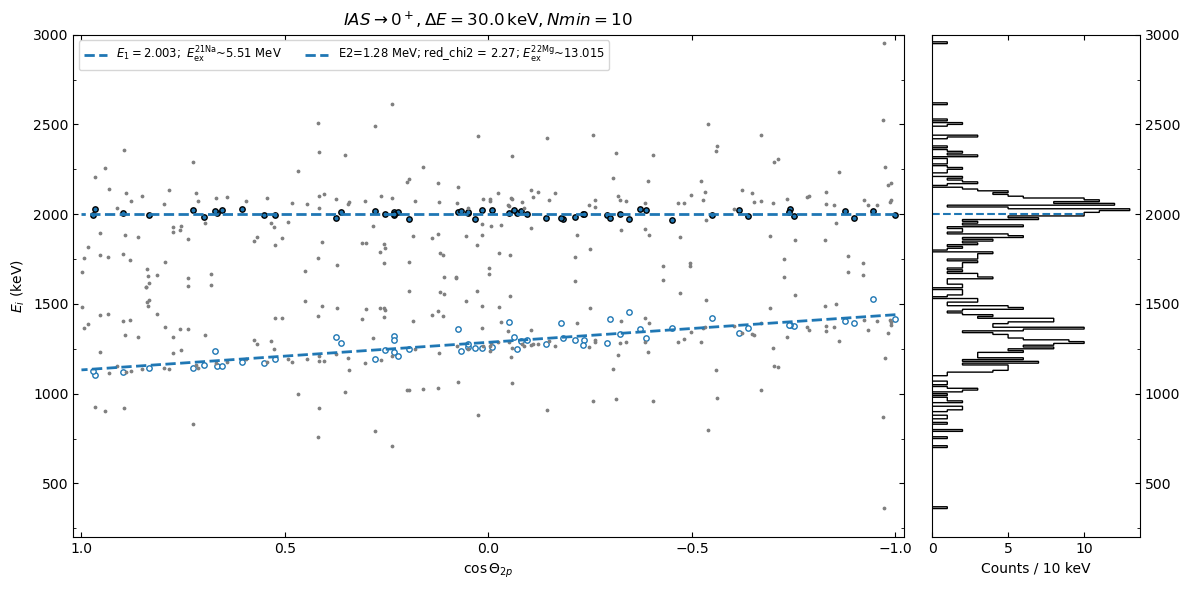

5432 -> ENSDF: [5457.]


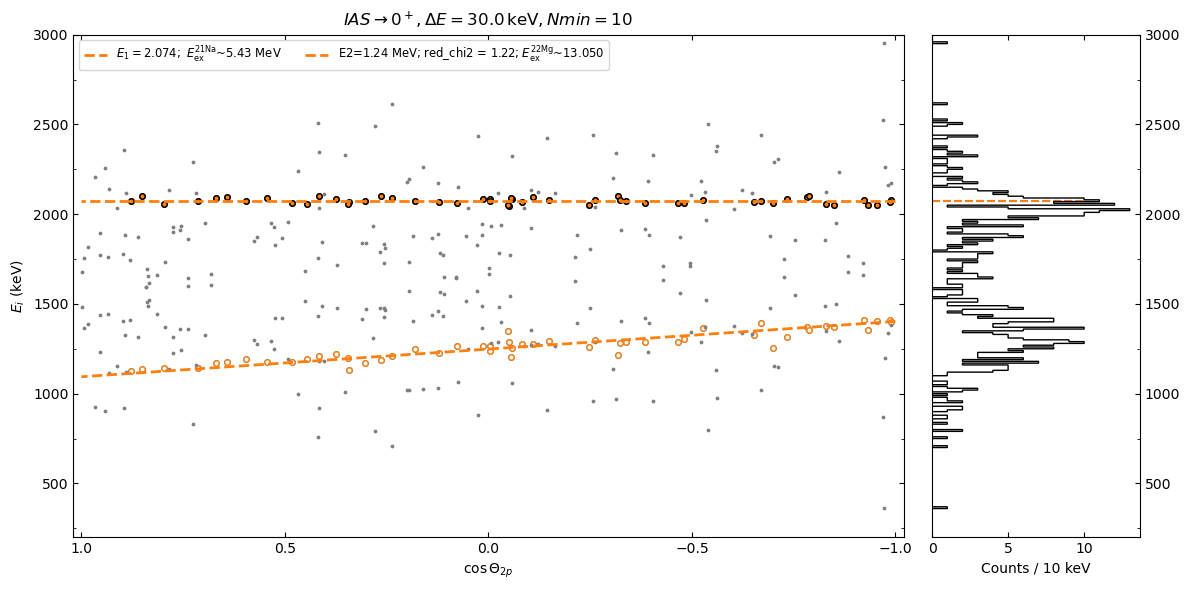

No suitable exctited level was found for 5654


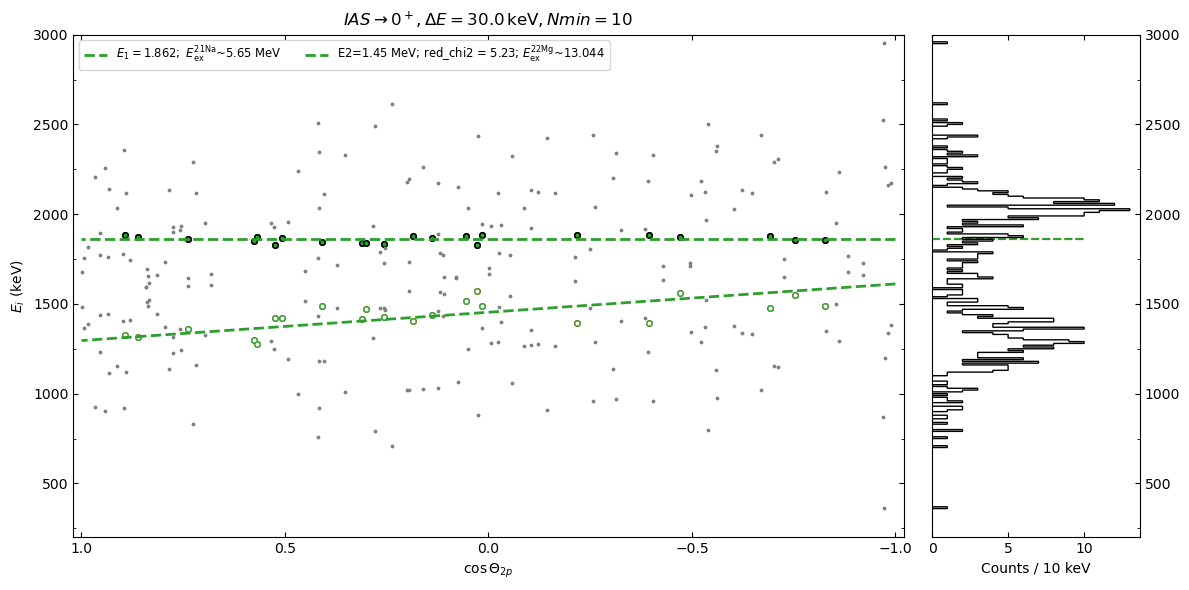

5767 -> ENSDF: [5770.]


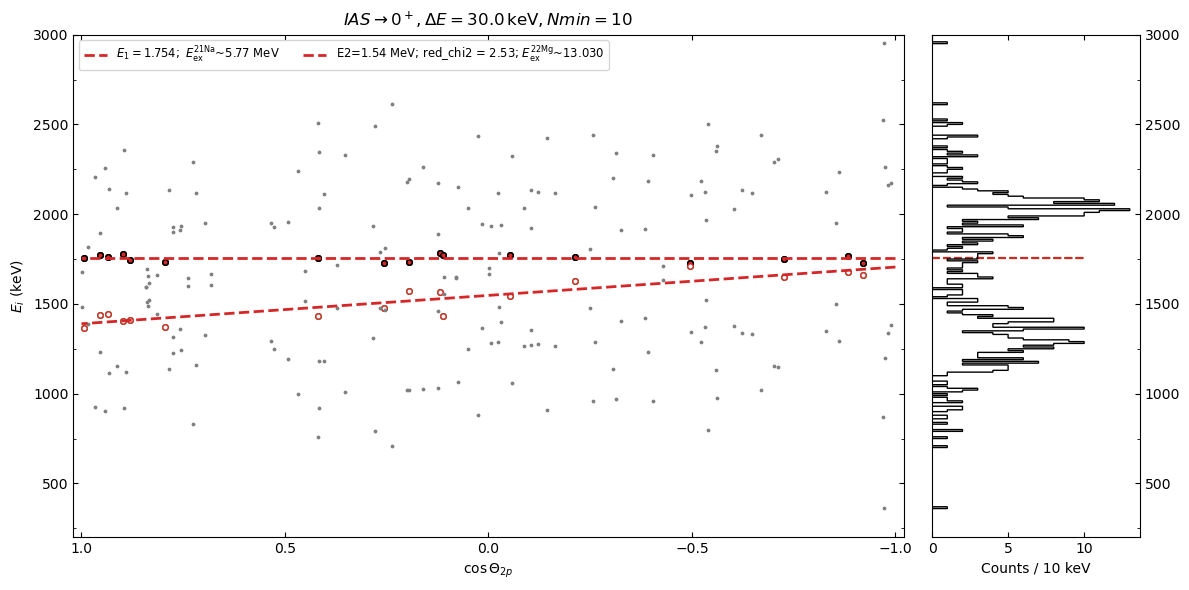

No suitable exctited level was found for 5580


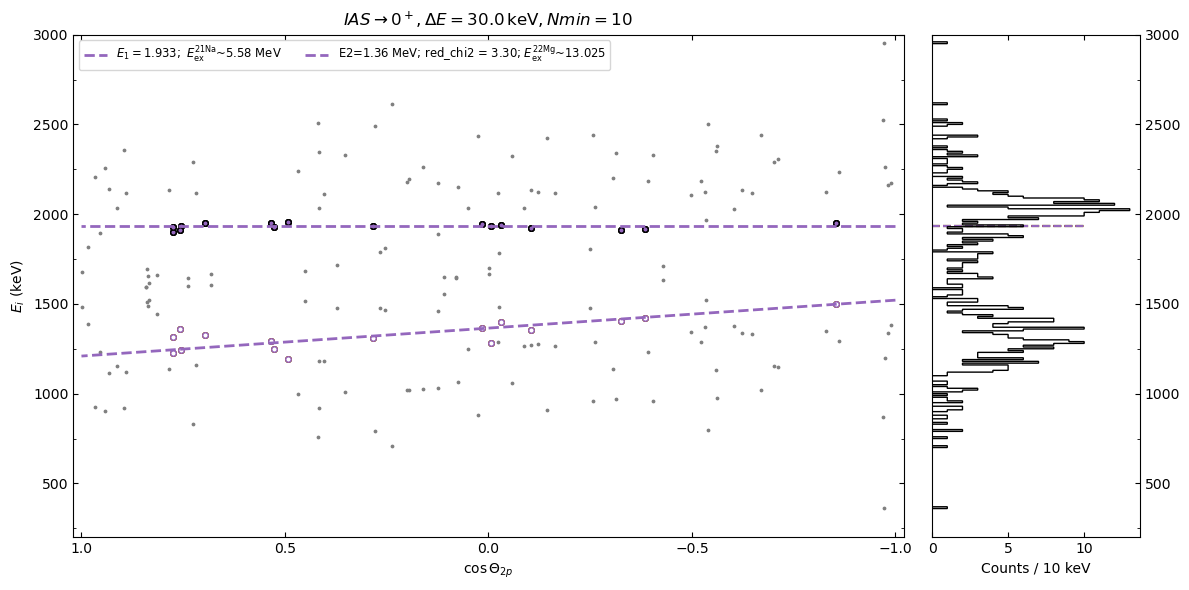

5377 -> ENSDF: [5380.]
5377 -> Erik: [5370.]


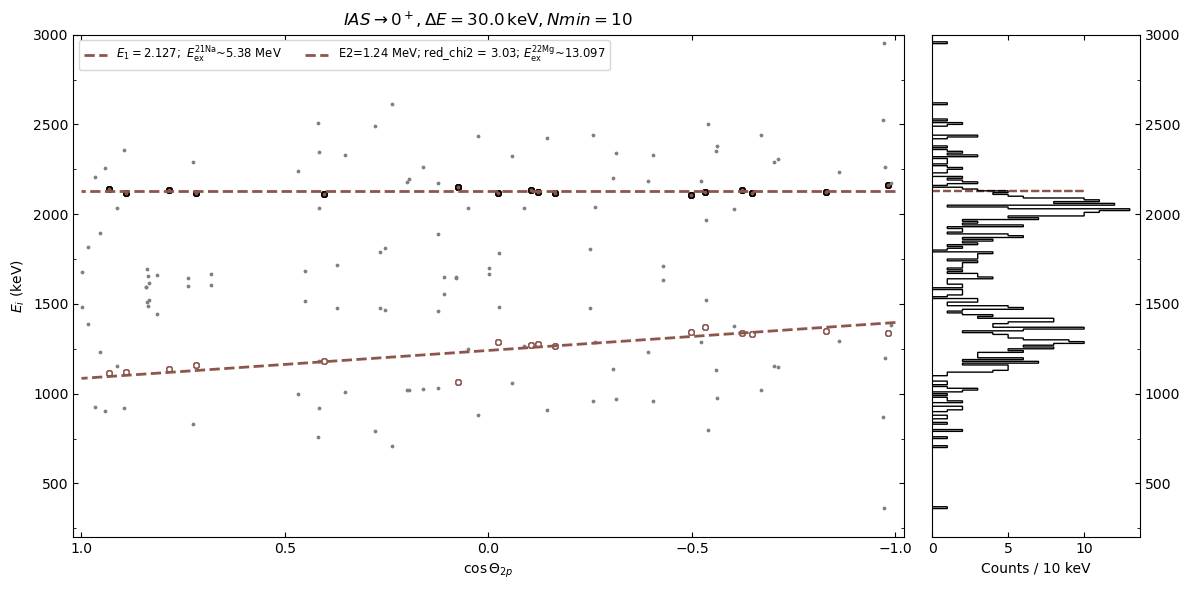

5863 -> ENSDF: [5884.]


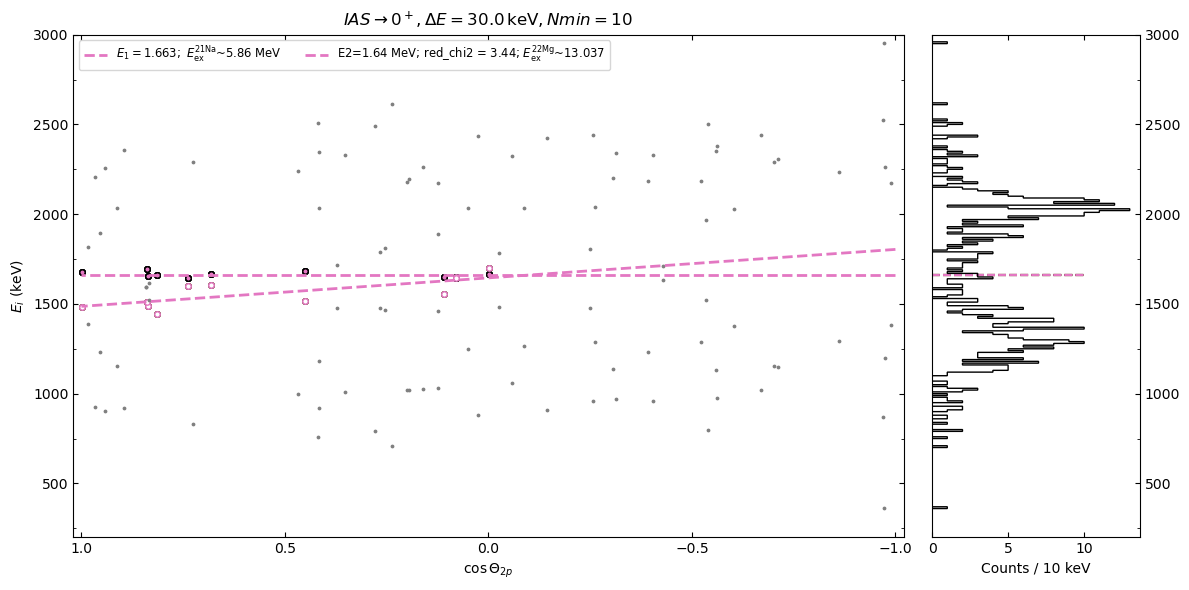

The reduced chi2 values from the fits
[2.271 1.216 5.232 2.525 3.299 3.031 3.438]

Peaks identified by previous studies of 21Na(found values)
[5432. 5767. 5377. 5863.]

Peaks found in Ensdf / Erik ?
[(True, False), (True, False), (True, True), (True, False)]

Peaks not found to match any previously found levels in 21Na
[5507. 5654. 5580.]

E1 energies:
[2003. 2074. 1862. 1754. 1933. 2127. 1663.]
E2 energies:
[1282. 1244. 1449. 1543. 1361. 1236. 1641.]
Excited state energies of 21Na:
[5507. 5432. 5654. 5767. 5580. 5377. 5863.]


In [21]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################
lim = (3370,3580)

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 30.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands0, e2bands0, cos1bands0, cos2bands0 = [], [], [], []
Ex, E1s,E2s = [], [], []
assigned_counts0 = [] ## following order of Ex

# ---- Q2p gate ----
m   = 6400
title = fr"$IAS \rightarrow 0^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
total_counts = len(e1)
N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = 13110 #(lim[0]+lim[1])/2+S2p+1634  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts0.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        assigned_counts0.append(0)

    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands0.append(E1_band)
    e2bands0.append(E2_band)
    cos1bands0.append(cos1_band)
    cos2bands0.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,10,color, ls='--')
        unused_cos0 = cos_th[event_band_idx == -1]
        unused_e10 = e1[event_band_idx == -1]
        unused_e20 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)

    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit+1634)/1e3:.3f}")

    Ex.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)

    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(200,3000)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    # ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))


No suitable exctited level was found for 3807


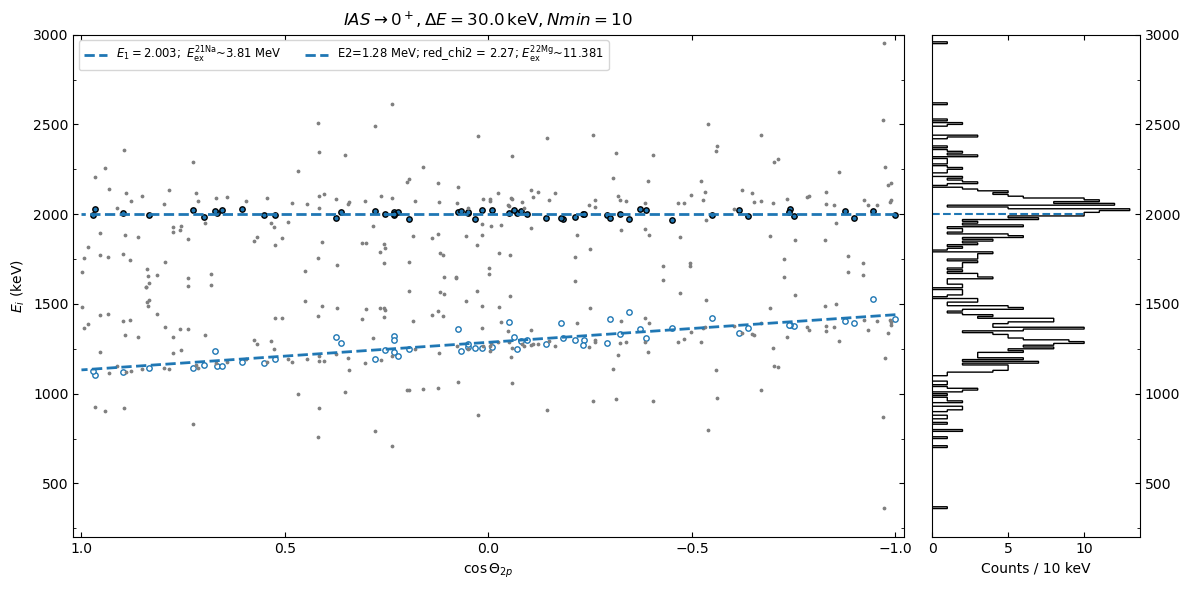

No suitable exctited level was found for 3732


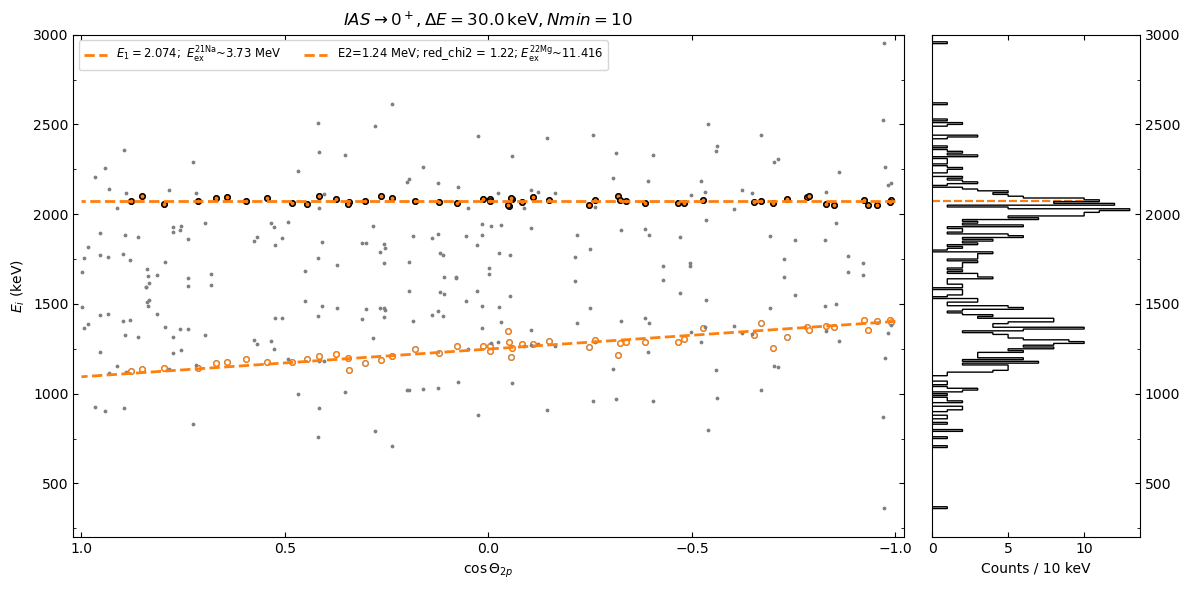

No suitable exctited level was found for 3954


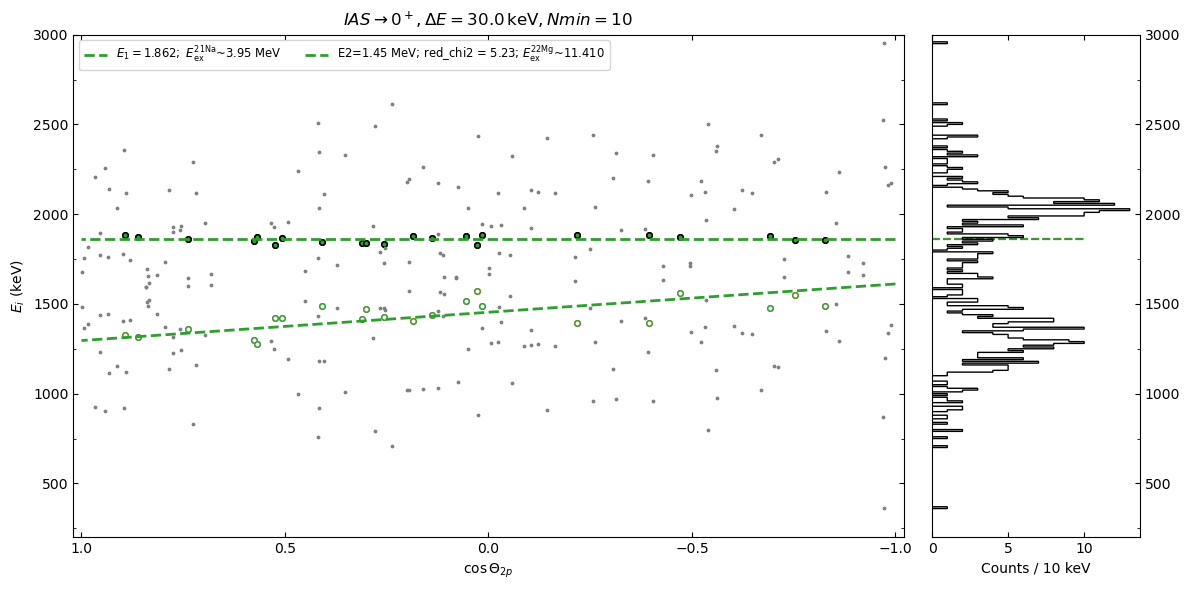

No suitable exctited level was found for 4067


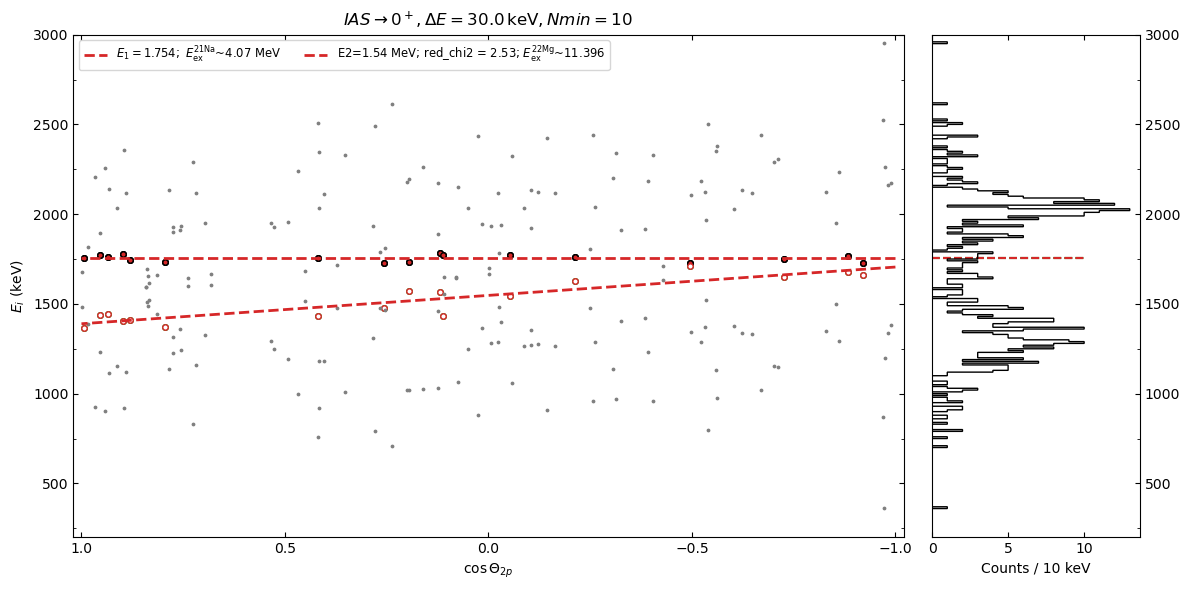

3880 -> ENSDF: [3862.2]
3880 -> Erik: [3860.]


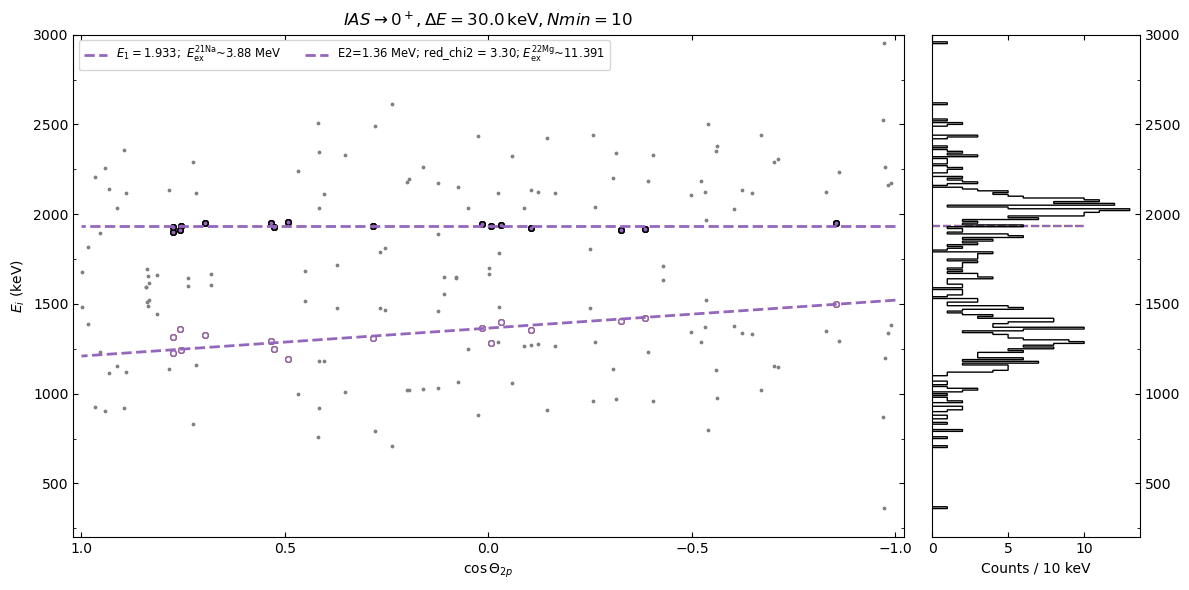

3677 -> ENSDF: [3678.9]


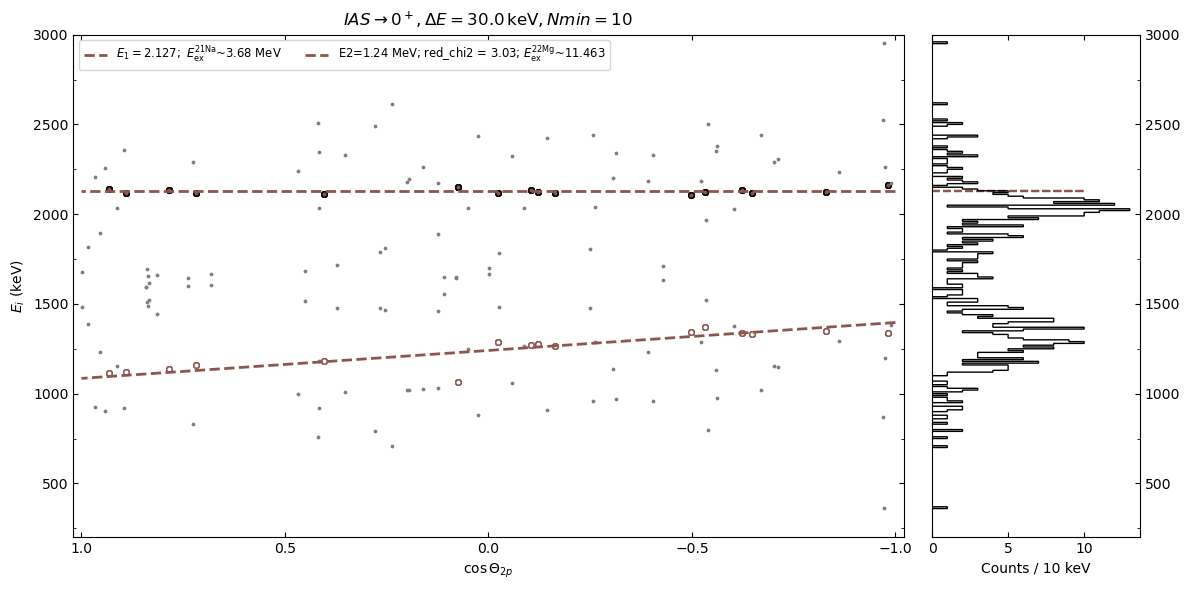

4163 -> ENSDF: [4169.6]


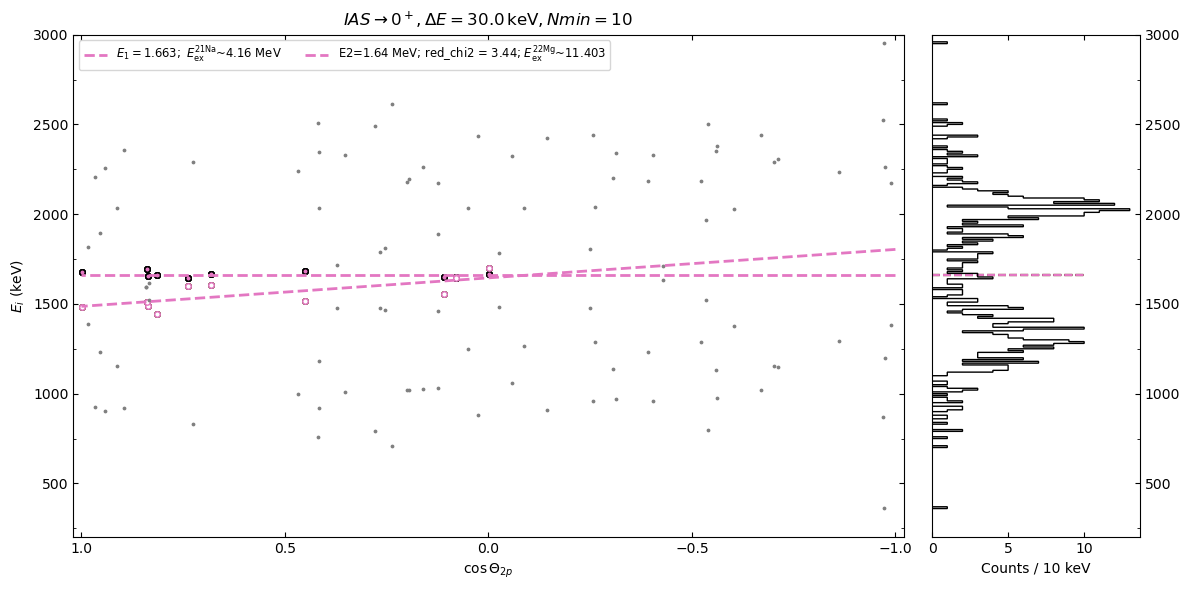

The reduced chi2 values from the fits
[2.271 1.216 5.232 2.525 3.299 3.031 3.438]

Peaks identified by previous studies of 21Na(found values)
[3880. 3677. 4163.]

Peaks found in Ensdf / Erik ?
[(True, True), (True, False), (True, False)]

Peaks not found to match any previously found levels in 21Na
[3807. 3732. 3954. 4067.]

E1 energies:
[2003. 2074. 1862. 1754. 1933. 2127. 1663.]
E2 energies:
[1282. 1244. 1449. 1543. 1361. 1236. 1641.]
Excited state energies of 21Na:
[3807. 3732. 3954. 4067. 3880. 3677. 4163.]


In [22]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################
lim = (3370,3580)

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 30.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands0, e2bands0, cos1bands0, cos2bands0 = [], [], [], []
Ex, E1s,E2s = [], [], []
assigned_counts0 = [] ## following order of Ex

# ---- Q2p gate ----
m   = 6400
title = fr"$IAS \rightarrow 0^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
total_counts = len(e1)
N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = 11410 #(lim[0]+lim[1])/2+S2p+1634  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts0.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        assigned_counts0.append(0)

    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands0.append(E1_band)
    e2bands0.append(E2_band)
    cos1bands0.append(cos1_band)
    cos2bands0.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,10,color, ls='--')
        unused_cos0 = cos_th[event_band_idx == -1]
        unused_e10 = e1[event_band_idx == -1]
        unused_e20 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)

    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit)/1e3:.3f}")

    Ex.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)

    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(200,3000)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    # ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))


3878 -> ENSDF: [3862.2]
3878 -> Erik: [3860.]


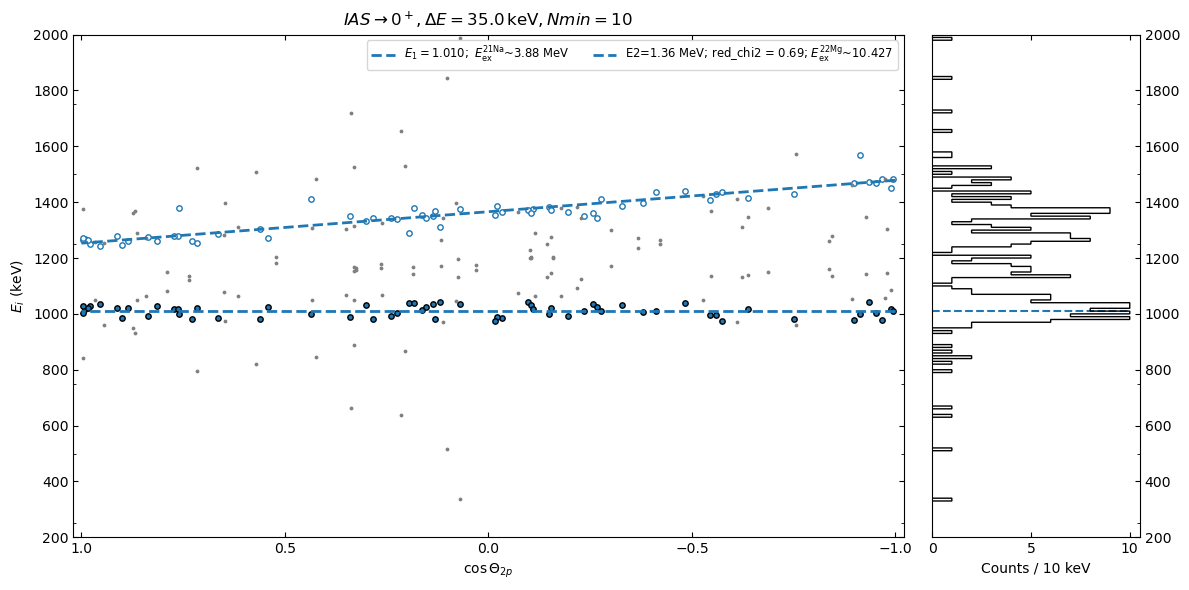

No suitable exctited level was found for 3720


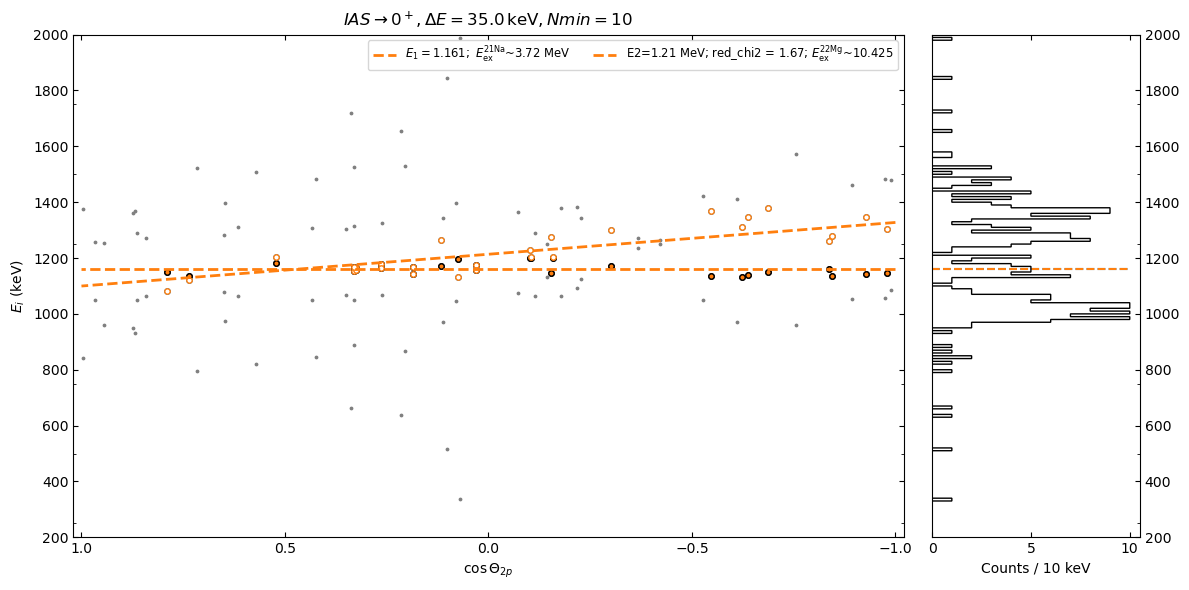

No suitable exctited level was found for 3823


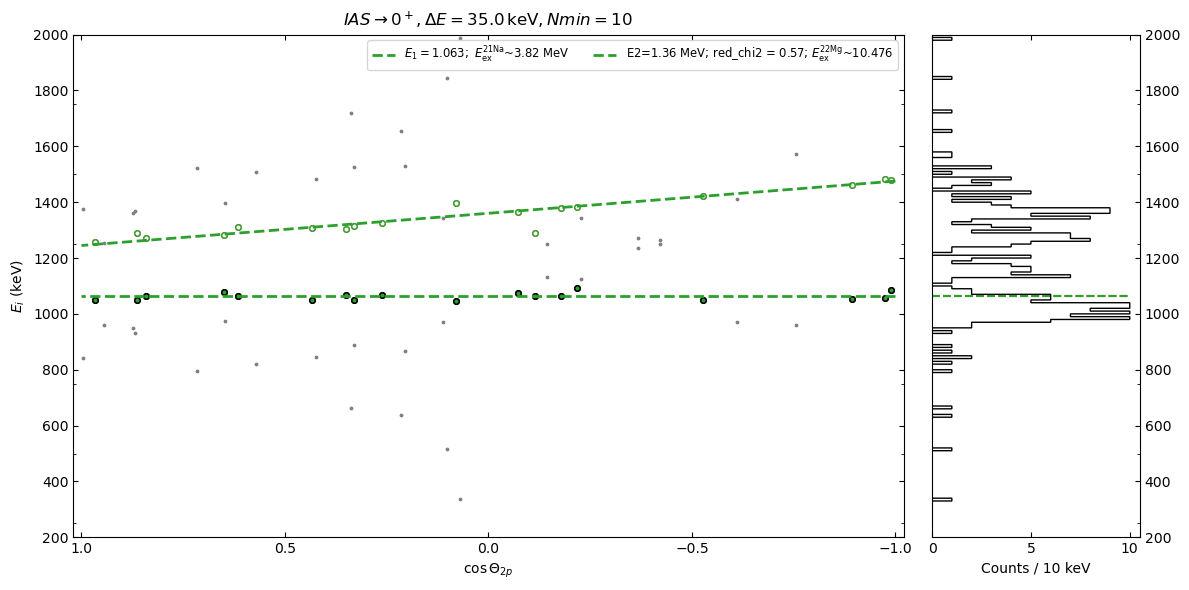

The reduced chi2 values from the fits
[0.691 1.674 0.568]

Peaks identified by previous studies of 21Na(found values)
[3878.]

Peaks found in Ensdf / Erik ?
[(True, True)]

Peaks not found to match any previously found levels in 21Na
[3720. 3823.]

E1 energies:
[1010. 1161. 1063.]
E2 energies:
[1364. 1211. 1358.]
Excited state energies of 21Na:
[3878. 3720. 3823.]


In [27]:
####################-----------------------------####################
#####
###
# This plotting tries to find lines with a specified dE(which essentially is the width of the peaks allowed)
# and tolerance(fitted E1 value distance to an already known 21Na level)
# and Nmin which specifies how many points we need in order to define a horizontal band
#
######------> This plotting routine does NOT reuse events <------######
#
###
#####
####################-----------------------------####################
lim = (2420,2590)

# ---- constant fit function ----
def horizontal_line(x, E0):
    return E0 + 0*x

# ---- parameters for horizontal band finder ----
Nmin = 10   # minimum events per band
dE   = 35.0 # keV tolerance
tolerance = 30

potential_excitedstates = []
potential_diffs_ensdf= []
potential_diffs_erik= []
ensdf_erik = []
vals=[]
reds = []
identifiable_peaks = []
non_matched_peaks = []
e1bands0, e2bands0, cos1bands0, cos2bands0 = [], [], [], []
Ex, E1s,E2s = [], [], []
assigned_counts0 = [] ## following order of Ex

# ---- Q2p gate ----
m   = 6400
title = fr"$IAS \rightarrow 0^+, \Delta E={dE} \, \mathrm{{keV}}, Nmin={Nmin}$"

mask = (Q2p >= lim[0]) & (Q2p <= lim[1])
cos_th = np.cos(np.deg2rad(theta[mask]))
e1 = np.array(E1[mask])
e2 = np.array(E2[mask])
Q2p_mean = lim[0] + (lim[1] - lim[0])/2
total_counts = len(e1)
N = len(e1)
if len(e2) != N:
    raise ValueError("e1 and e2 must have the same length (one entry per event).")

# ---- iterative band finder with strict event exclusion ----
unassigned = np.ones(N, dtype=bool)   # events available for band finding
event_band_idx = np.full(N, -1)       # store which band each event belongs to (-1 = unassigned)
bands = []
band_index = 0

colors = plt.cm.tab10.colors

while True:
    # candidate energies from unassigned events
    cand_e1 = e1[unassigned]
    cand_e2 = e2[unassigned]
    if cand_e1.size + cand_e2.size == 0:
        break

    candidates = np.concatenate([cand_e1, cand_e2])
    best = None  # (count, Ecand, inlier_events_mask)

    # find the candidate that produces the most events
    for Ecand in candidates:
        mask_e1_close = (np.abs(e1 - Ecand) <= dE)
        mask_e2_close = (np.abs(e2 - Ecand) <= dE)
        inlier_events = (mask_e1_close | mask_e2_close) & unassigned
        n = inlier_events.sum()
        if best is None or n > best[0]:
            best = (n, Ecand, inlier_events)

    if best is None or best[0] < Nmin:
        break  # no more acceptable bands

    count, Ecand_best, inlier_events = best
    # mark these events as belonging to this band
    event_band_idx[inlier_events] = band_index
    bands.append((inlier_events, Ecand_best, count))

    # split mask into e1 and e2 (same as your original logic)
    mask_e1 = (np.abs(e1 - Ecand_best) <= dE) & unassigned
    mask_e2 = (np.abs(e2 - Ecand_best) <= dE) & unassigned

    # ---- build arrays for fitting ----
    E1_band = np.concatenate([np.array(e1[mask_e1]), np.array(e2[mask_e2])])
    cos1_band = np.concatenate([np.array(cos_th[mask_e1]), np.array(cos_th[mask_e2])])

    E2_band = np.concatenate([np.array(e1[mask_e2]), np.array(e2[mask_e1])])
    cos2_band = np.concatenate([np.array(cos_th[mask_e2]), np.array(cos_th[mask_e1])])

    # ---- fit horizontal line to E1_band ----
    p_opt1, _ = curve_fit(horizontal_line, cos1_band, E1_band)
    E1_fit = p_opt1[0]
    Q1_fit = E1_fit*(mNa + mp)/mNa

    # ---- fit y2 as in your original script ----
    popt2, _ = curve_fit(y2, cos2_band, E2_band, p0=[p_opt1[0], Q2p_mean-Q1_fit],
                         bounds=([E1_fit,0],[E1_fit+1e-12,Q2p_mean]))
    E2_fit = popt2[1]
    Q2_fit = E2_fit*(mNe + mp)/mNe
    E2_min = y2(1, E1_fit, E2_fit)
    E2_max = y2(-1, E1_fit, E2_fit)

    mgex = (lim[0]+lim[1])/2+S2p  # (S2p+Q1_fit+Q2_fit)
    sigma_guess = dE
    residuals = E2_band - y2(cos2_band, *popt2)
    dof = max(1, len(E2_band)-len(popt2))
    reduced_chi2 = np.sum((residuals/sigma_guess)**2)/dof
    reds.append(reduced_chi2)

    potential_excitedstates.append((mgex-S1p-E1_fit/frac)/1e3)

    diff_ensdf = (E_excited-(mgex-S1p-E1_fit/frac))
    diff_erik = (Erik_Es- (mgex-S1p-E1_fit/frac))

    match_ensdf_exists = np.any(np.abs(diff_ensdf) <= tolerance)
    match_erik_exists = np.any(np.abs(diff_erik) <= tolerance)

    match_erik = np.NaN
    match_ensdf = np.NaN
    if match_ensdf_exists:
        match_ensdf = E_excited[np.abs(diff_ensdf) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> ENSDF: {match_ensdf}")
    if match_erik_exists:
        match_erik = Erik_Es[np.abs(diff_erik) <= tolerance]
        print(f"{(mgex-S1p-E1_fit/frac):.0f} -> Erik: {match_erik}")

    if match_ensdf_exists or match_erik_exists:
        identifiable_peaks.append((mgex-S1p-E1_fit/frac))
        ensdf_erik.append((match_ensdf_exists,match_erik_exists))
        vals.append((match_ensdf, match_erik))
        assigned_counts0.append(len(cos1_band))
    if not match_erik_exists and not match_ensdf_exists:
        print(f"No suitable exctited level was found for {(mgex-S1p-E1_fit/frac):.0f}")
        non_matched_peaks.append(mgex-S1p-E1_fit/frac)
        assigned_counts0.append(0)

    # ---- plotting ----
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(12,6), sharey=True,
        gridspec_kw={'width_ratios':[4,1]}
    )
    e1bands0.append(E1_band)
    e2bands0.append(E2_band)
    cos1bands0.append(cos1_band)
    cos2bands0.append(cos2_band)
    # plot already assigned events in their colors
    cols = []
    for b_idx in range(band_index+1):
        cols.append(colors[b_idx % len(colors)])
        color = colors[b_idx % len(colors)]
        ax1.scatter(cos1_band, E1_band, s=15, facecolors=color, edgecolors='k')
        ax1.scatter(cos2_band, E2_band, s=15, facecolors='white', edgecolors=color)
        ax2.hlines(E1_fit, 0,10,color, ls='--')
        unused_cos0 = cos_th[event_band_idx == -1]
        unused_e10 = e1[event_band_idx == -1]
        unused_e20 = e2[event_band_idx == -1]
    
    
    #if match_ensdf_exists or match_erik_exists:
        #for a,b,x1,x2,c in zip(e1bands,e2bands,cos1bands,cos2bands,cols):
        #    ax1.scatter(x1, a, s=15, facecolors=c, edgecolors='k')
        #    ax1.scatter(x2, b, s=15, facecolors='white', edgecolors=c)

    # plot unassigned events in gray
    mask_unassigned = (event_band_idx == -1)
    ax1.scatter(cos_th[mask_unassigned], e1[mask_unassigned], color='gray', s=3)
    ax1.scatter(cos_th[mask_unassigned], e2[mask_unassigned], color='gray', s=3)

    # plot fitted lines
    x_plot = np.linspace(-1, 1, 200)
    ax1.plot(x_plot, horizontal_line(x_plot, E1_fit), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, label=rf"$E_{1}={E1_fit/1e3:.3f}; \ E_{{\mathrm{{ex}}}}^{{{21}\mathrm{{Na}}}}$~{(mgex-S1p-E1_fit/frac)/1e3:.2f} MeV")
    ax1.plot(x_plot, y2(x_plot, *popt2), color=colors[band_index % len(colors)],
             linestyle='--', linewidth=2, 
             label=rf"E2={popt2[1]/1e3:.2f} MeV; red_chi2 = {reduced_chi2:.2f}; $E_{{\mathrm{{ex}}}}^{{{22}\mathrm{{Mg}}}}$~{(S2p+Q1_fit+Q2_fit)/1e3:.3f}")

    Ex.append(mgex-S1p-E1_fit/frac)
    E1s.append(E1_fit)
    E2s.append(E2_fit)

    ax1.set_xlabel(r"$\cos\Theta_{2p}$")
    ax1.set_ylabel(r"$E_i$ (keV)")
    ax1.set_title(title)
    ax1.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_xticks(np.arange(1,-1.5,-0.5))
    ax1.set_xlim(1.02,-1.02)
    ax1.legend(fontsize='small', ncol=5)

    # ---- histogram ----
    bins = np.arange(0, 7000+10, 10)
    h1, _ = np.histogram(e1, bins=bins)
    h2, _ = np.histogram(e2, bins=bins)
    ax2.hist(bins[:-1], bins=bins, weights=h1+h2, histtype='step',
            orientation='horizontal', color='k')
    ax2.set_xlabel('Counts / 10 keV')
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticks(np.arange(0, m, 250), minor=True)
    ax1.set_ylim(200,2000)

    fig.subplots_adjust(wspace=0.1, left=0.08, right=0.95, top=0.9, bottom=0.1)
    plt.tight_layout()
    plt.show()

    # ---- exclude events used in this band for next iteration ----
    unassigned[inlier_events] = False
    band_index += 1

# ---- final summary printouts ----
print("The reduced chi2 values from the fits")
print(np.round(reds,3))
print()
print("Peaks identified by previous studies of 21Na(found values)")
print(np.round(identifiable_peaks,0))
print()
print("Peaks found in Ensdf / Erik ?")
print(ensdf_erik)
print()
print("Peaks not found to match any previously found levels in 21Na")
print(np.round(non_matched_peaks,0))
print()
print("E1 energies:")
print(np.round(E1s,0))
print("E2 energies:")
print(np.round(E2s,0))
print("Excited state energies of 21Na:")
print(np.round(Ex,0))
